## Tổng quan

### Mục tiêu 
Mục tiêu bài viết này nhằm giới thiệu đến bạn xây dựng mô hình chuỗi thời gian trong Tensorflow, cụ thể chúng ta sẽ xây dựng mô hình dự đoán Bitcoin 

> 🔑**Lưu ý** : Trong bài viết này sẽ chỉ tập trung xây dựng mô hình để dự đoán dữ liệu, chúng ta sẽ không đi sâu vào khía cạnh tài chính vì đó là một chủ đề rất phức tạp.

### Vấn đề chuỗi thời gian là gì?

Là những dữ liệu được hình thành qua thời gian. VD giá cổ phiếu của mỗi ngày, số lượng đơn hàng của một công ty được chốt theo một quý, số lượng vé máy bay dựa theo mùa... 

Mốc thời gian có thể ngắn (giây/mili giây) hoặc dài (tháng/ quý/ năm/...)tùy thuộc vào loại dữ liệu của vấn đề cần được xử lý. 

Vấn đề xử lý dữ liệu theo chuỗi thời gian được chia làm 2 loại : 

| Loại | VD | Output | 
| ---- | ---| ------ | 
| Phân loại (classification) | Phát hiện bất thường, nhận diện chuỗi thời gian (chuỗi thời gian đó đến từ đâu?) | Rời rạc (label) | 
| Dự báo (forecast) | Dự đoán giá cổ phiếu, hoặc lượng cung/ cầu hàng hóa, dự báo tồn kho | Liên tục (continues) | 

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

Trong cả hai trường hợp trên, phương pháp học có giám sát thường được sử dụng. Có nghĩa là, bạn sẽ có một số dữ liệu mẫu và một label được liên kết với dữ liệu đó. Ví dụ: trong dự báo giá Bitcoin, dữ liệu của bạn có thể là giá lịch sử của Bitcoin trong tháng qua và label có thể là giá hôm nay (label không thể là giá ngày mai vì đó là những gì chúng ta muốn dự đoán).

### Dữ liệu sử dụng 
Dữ liệu bitcoin lấy từ https://finance.yahoo.com/quote/BTC-USD/history từ ngày 17/09/2014 đến 27/09/2021. 

### Bối cảnh 
Bitcoin, một trong những đồng tiền điện tử được sử dụng rộng rãi nhất trên toàn cầu. Tuy nhiên, độ biến động của đồng tiền nay cũng không hề nhỏ nên nó khiến rất nhiều nhà đầu tư phải đâu đầu với các chiến lược trading sao cho hiệu quả. Qua dữ liệu này, chúng ta sẽ tiến hành dự đoán qua các mô hình dự đoán dòng tiền trong tương lai.

### Nội dung của bài viết : 
1. Lấy dữ liệu chuỗi thời gian (giá lịch sử của Bitcoin) và khám phá dữ liệu
2. Định dạng dữ liệu chuỗi thời gian
  + Tạo dữ liệu train và test
  + Chia dữ liệu thành horizon và window
  + Chuẩn bị dữ liệu đơn biến và đa biến (nhiều hơn một biến)
3. Tạo các callbacks để theo dõi quá trình train của mô hình
4. Hiểu về đánh giá mô hình dự báo. 
5. Thiết lập và train mô hình
  + Model 0 : Naive Bayes 
  + Model 1 : Dense Model (window = 7, horizon = 1) 
  + Model 2 : Dense Model (window = 30, horizon = 1) 
  + Model 2 : Sequence models (LSTM và  CNN) 
  + Hỗn hợp (Kết hợp nhiều mô hình với nhau ) 
  + Mô hình đa biến 
  + Sao chép thuật toán N-BEATS
6. Đánh giá mô hình dự báo chuỗi thời gian
7. Mô hình dự đoán dữ liệu 
8. Tạo khoảng thời gian dự đoán cho các dự báo chuỗi thời gian
9. Thảo luận về hai loại không chắc chắn khác nhau trong học máy (độ không đảm bảo của dữ liệu và độ không đảm bảo của mô hình)



In [1]:
import numpy  as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import Sequential, Model, layers

In [2]:
!wget https://www.dropbox.com/s/2yc6hxhkkqphu5e/bitcoin.csv

--2021-10-01 07:00:35--  https://www.dropbox.com/s/2yc6hxhkkqphu5e/bitcoin.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2yc6hxhkkqphu5e/bitcoin.csv [following]
--2021-10-01 07:00:35--  https://www.dropbox.com/s/raw/2yc6hxhkkqphu5e/bitcoin.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63f3e671da339c5eae3aacdaae.dl.dropboxusercontent.com/cd/0/inline/BXPGToG2Cl7XG_edny4nu0QmFoaS-6vnCT-Asqpwnubsski_RIHNdsVhIy5iYkw4POWQ6XomVn575SjIPd3EjjcaI4PxNXeGT7mR6iT3j2yQEKBe4rtA4oO_NEBUEnyXQ0cFPnoGHmUWCahm7kglo66j/file# [following]
--2021-10-01 07:00:35--  https://uc63f3e671da339c5eae3aacdaae.dl.dropboxusercontent.com/cd/0/inline/BXPGToG2Cl7XG_edny4nu0QmFoaS-6vnCT-Asqpwnubsski_RIHNdsVhIy5iYkw4POWQ6XomVn575SjIPd3EjjcaI4PxN

Chúng ta sẽ sử dụng thư viên pandas để đọc tệp `bitcoin.csv` và sử dụng tham số `parse_dates=True` để chuyển dữ liệu thành kiểu `datetime`  và `index_col='Date'` để lấy cột `Date` làm index

In [3]:
bitcoin = pd.read_csv("bitcoin.csv", parse_dates=True, index_col="Date")

Check thông tin sơ lược của `bitcoin`. 

In [4]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2568 entries, 2014-09-17 to 2021-09-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2564 non-null   float64
 1   High       2564 non-null   float64
 2   Low        2564 non-null   float64
 3   Close      2564 non-null   float64
 4   Adj Close  2564 non-null   float64
 5   Volume     2564 non-null   float64
dtypes: float64(6)
memory usage: 140.4 KB


Trong `bitcoin` có tất cả 6 cột, nhưng chúng ta thực sự chỉ cần quan tâm cột `Close` (giá khi đóng cửa). Giá đóng cửa của một cổ phiếu hay một loại giao dịch chứng khoán có ý nghĩa tài chính của nó, nhưng chúng ta sẽ không đi sâu phần này. 

In [5]:
bitcoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [6]:
bitcoin.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-23,43560.296875,44942.175781,43109.339844,44895.097656,44895.097656,3.424406e+10
2021-09-24,44894.300781,45080.492188,40936.558594,42839.750000,42839.750000,4.283935e+10
2021-09-25,42840.890625,42996.257813,41759.921875,42716.593750,42716.593750,3.160472e+10
2021-09-26,42721.628906,43919.300781,40848.460938,43208.539063,43208.539063,3.066122e+10
2021-09-27,43188.097656,44292.847656,43022.328125,43308.800781,43308.800781,2.972908e+10


Để mô tả dữ liệu chúng ta sử dụng phương thức `describe()`

In [7]:
bitcoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2.564000e+03
mean,9089.087123,9345.536550,8807.138019,9105.004822,9105.004822,1.355796e+10
std,13332.845737,13730.920254,12870.456170,13347.906610,13347.906610,1.985585e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,575.552750,580.579987,570.915985,575.520737,575.520737,7.304235e+07
50%,5301.157471,5419.827637,5217.846680,5309.171875,5309.171875,4.450275e+09
75%,9629.642090,9794.140381,9414.048584,9631.344727,9631.344727,2.156101e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


> 🔑 Lưu ý: Tần suất thu thập mẫu dữ liệu chuỗi thời gian thường có tính thời vụ. Điều này thường được tạo ra với số lượng mẫu mỗi năm. Ví dụ: thu thập giá Bitcoin một lần mỗi ngày sẽ tạo chuỗi thời gian có tính thời vụ là 365. Dữ liệu chuỗi thời gian được thu thập với các giá trị thời vụ khác nhau thường thể hiện các mô hình theo mùa (ví dụ: nhu cầu điện tăng cao hơn trong các tháng Mùa hè do thời tiết nóng nên phải sử dụng máy điều hòa không khí so với các tháng Mùa đông). Xem thêm tại [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)

Như đã đề cập ở trên, chúng ta sẽ chỉ quan tâm đến cột `Close` để xây dựng mô hình với dữ liệu trong cột này. 

Trước tiên chúng ta sẽ xem biểu đồ giá của bitcoin lúc đóng cửa mỗi ngày kể từ ngày 17/09/2014 đến 27/09/2021




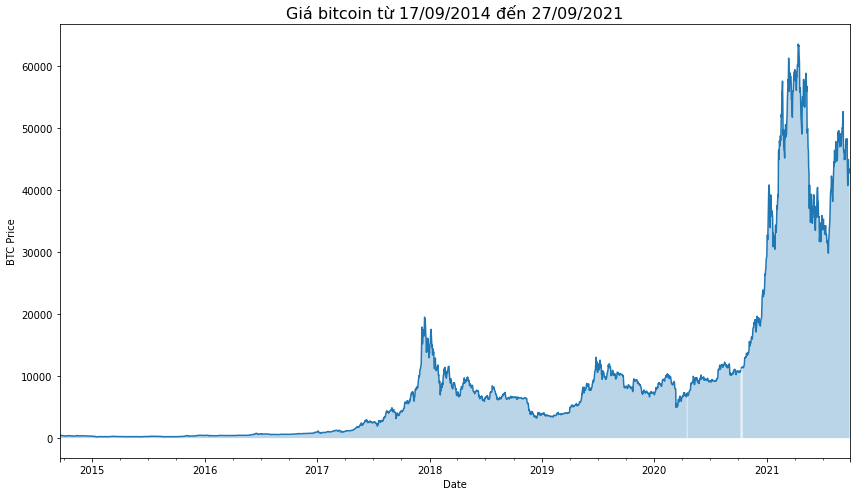

In [8]:
bitcoin["Close"].plot(figsize=(12,7))
plt.fill_between(bitcoin.index,bitcoin["Close"],alpha=0.3,)
plt.ylabel("BTC Price")
plt.title("Giá bitcoin từ 17/09/2014 đến 27/09/2021", fontsize=16)
plt.tight_layout()

In [9]:
bitcoin_close = pd.DataFrame(bitcoin["Close"])
bitcoin_close.columns = ["Close"]
bitcoin_close

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-09-23,44895.097656
2021-09-24,42839.750000
2021-09-25,42716.593750


Kiểm tra dữ liệu có được toàn vẹn hay không, nếu không cần xóa các ô bị bỏ trống. 

In [10]:
bitcoin_close.isna().any()

Close    True
dtype: bool

In [11]:
bitcoin_close.dropna(axis=0, inplace=True)

In [12]:
bitcoin_close

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-09-23,44895.097656
2021-09-24,42839.750000
2021-09-25,42716.593750


## 2. Định dạng dữ liệu chuỗi thời gian

Thông thường, bạn có thể tạo một tách dữ liệu thành `train` và `test` với `train_test_split()` nhưng điều này không thực sự cắt nó đối với dữ liệu chuỗi thời gian. Trước khi chúng tách dữ liệu, chúng ta cần biết dữ liệu hiển tại là gì, thuôc loại dữ liệu nào (dữ liệu đơn hay dữ liệu đa biến). 

+ **Dữ liệu đơn biến (uninvariate)** : Sử dụng dữ liệu chuỗi thời gian với một biến, VD: sử dụng giá Bitcoin để dự đoán giá Bitcoin.
+ **Dữ liệu đa biến (multivariate)** : Sử dụng dữ liệu chuỗi thời gian với nhiều biến. VD : Dự đoán số ca nhiễm COVID-19 trong ngày dựa trên dữ liệu mật độ dân cư, số người bị nhiễm trong vùng, tỉ lệ chích vaccine... 

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)


### Tạo tập dữ liệu train và test





Mục tiêu của chúng ta là xây dựng mô hình để dự đoán giá bitcoin (hoặc stock) trên dữ liệu chuỗi thời gian nên thứ tự của các dữ liệu rất quan trọng vì chúng có mối quan hệ tương quan với nhau (có khuynh hướng theo chu kỳ, theo mùa). Vì thế, khi tách dữ liệu, chúng ta sẽ không đảo lộn thứ tự của các dữ liệu và chia dữ liệu làm 2 phần, dữ liệu quá khứ (train) và dữ liệu tương lai(test). 

Dữ liệu tương lai ở đây có thể hiểu là dữ liệu ở thời điểm sau môt thời điểm của quá khứ chứ không phải là tương lai so với thực tại của chúng ta vì không thể nào có thể biết được dữ liệu tương lai sẽ như thế nào.

Dữ liệu mà chúng ta có được đã được sắp xếp một cách có thứ tự theo thời gian. Như vậy, chúng ta sẽ lấy 80% dữ liệu đầu tiên làm dữ liệu `train` và 20% dữ liệu cuối cùng để kiểm định hoặc test.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

Để tách dữ liệu nhanh chóng, chúng ta sẽ tận dụng lại `train_test_split()` nhưng sẽ có thêm thuộc tính `shuffle=False` để dữ liệu được giữ nguyên theo thứ tự 

In [13]:
timesteps = bitcoin_close.index.to_numpy()
prices = bitcoin_close["Close"].to_numpy()
timesteps[:5], prices[:5]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014]))

Chúng ta sẽ sử dụng `train_test_split()` để tách dữ liệu như sau : 

In [14]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, 
                                                    prices, 
                                                    train_size=0.8,
                                                    shuffle=False,)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2051,), (513,), (2051,), (513,))

OK, dữ liệu đã được tách, chúng ta sẽ quan sát dữ liệu trên biểu đồ. Đặc biệt, biểu đồ này sẽ được áp dụng ở những phần sau nên chúng ta sẽ tạo hàm để có thể tái sử dụng

In [16]:
def plot_time_series(X,y,start=0, end=None, format=".", label=None) : 
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time 
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  format : style of plot, default "."
  label : label to show on plot of values
  """
  plt.plot(X[start:end], y[start:end], format, label=label)
  plt.xlabel("Thời gian")
  plt.ylabel("Giá Bitcoin")
  if label : 
    plt.legend(fontsize=14)
  plt.grid(True)

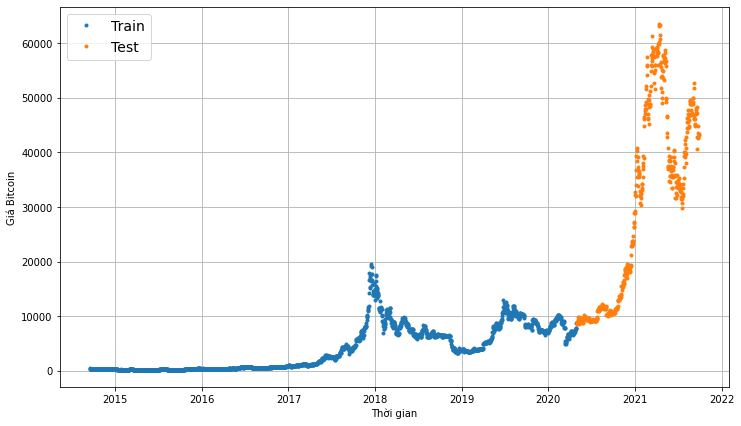

In [17]:
plt.figure(figsize=(12,7))
plot_time_series(X_train, y_train, label="Train")
plot_time_series(X_test, y_test, label="Test")

### Chia dữ liệu thành horizon và window 

Để giúp mô hình có thể được train tốt nhất, dữ liệu đưa vào(input) và dữ liệu xuất ra cũng (output) là một trong những yếu tố cực kỳ quan trọng. Phần trên chúng ta đã tách dữ liệu theo thời gian, nghĩa là cứ mỗi ngày sẽ có một dữ liệu mẫu. 

Nhưng như đã nói, dữ liệu chuỗi thời gian thường có sự kết nối với nhau, thời điểm trước có  mối liên hệ đến thời điểm sau, các dữ liệu có tính chu kỳ, mùa vụ hoặc có một vòng tuần hoàn. Do đó, chúng ta còn có thể tách dữ liệu thành một chuỗi dữ liệu trong quá khứ để phục vụ cho một hoặc một chuỗi dữ liệu xảy ra cho tương lai. Đó là ý tưởng để chúng ta tạo chuỗi dữ liệu như vây, và thuật ngữ nó có tên là `horizon` và `window`

+ `window` : Số lượng dữ liệu theo thời gian trong quá khứ để dự đoán
+ `horizon` :Số lượng dữ liệu theo thời gian được hình thành tiếp sau dữ liệu trong quá khứ `window`, có thể hiểu nó chính là `label` để mô hình train xong có thể tham chiếu đến.

VD : Dữ hôm nay là ngày thứ 2, giá bitcoin là `$42.000` và xem như đây là dữ liệu để dự đoán, chúng ta sẽ lấy dữ liệu của 7 ngày trước tạo thành một chuỗi và thử dự đoán xem dữ liệu ngày hôm nay là bao nhiêu rồi đem so sánh với dữ liệu thực `$42.000`

`horizon` và `window` sẽ được chia như sau để phục vụ cho các thử nghiệm mô hình : 

| Thứ tự mô hình | Kiểu mô hình  | Kích thước Horizon | Kích thước Window | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

Windowing là một phương pháp để biến một tập dữ liệu chuỗi thời gian thành một bài toán học có giám sát. Nói cách khác, chúng ta muốn sử dụng dữ liệu của quá khứ để dự đoán tương lai. 

```
Window cho 1 tuần (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Hoặc đối với giá Bitcoin, nó sẽ giống như sau:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)

Ở phần này, chúng ta sẽ viết hàm đến khi nào sử dụng mô hình cụ thể chúng ta sẽ đưa dữ liệu vào trong hàm để tạo dữ liệu. 



In [18]:
def get_windows_labels(data, horizon=1) : 
  """
  Tách dữ liệu thành window và labels 
  VD : Nếu horizon = 1 thì : 
  Input : [[1,2,3,4,5,6]] 
  Output : ([1,2,3,4,5], [6])
  """
  return data[:, :-horizon], data[:, -horizon:]

In [19]:
import tensorflow as tf

example = tf.expand_dims(np.arange(8) + 1,axis=0)
window, label = get_windows_labels(example)
print(f"Window: {window} -> Label : {label}")

Window: [[1 2 3 4 5 6 7]] -> Label : [[8]]


Bây giờ, chúng ta cần tạo windows và horizon cho toàn bộ dữ liệu chuỗi thời gian.

Chúng ta có thể thực hiện vòng lặp nhưng với dữ liệu lớn sẽ mất rất nhiều thời gian. Tuy nhiên, để tăng tốc quá trình này, chúng ta có thể tận dụng [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Tạo một hàm với các tham số : 
+ `data` : dữ liệu 
+ `window` : số phần tử trong một window
+ `horizon` : số label 




In [20]:
def create_windows(data, window=7, horizon=1, ) : 
  # Tạo một mask với kích thước của window + horizon được đánh số thư tự VF :  [[0, 1, 2, 3, 4, 5, 6, 7]]
  window_mask = np.arange(window+horizon)
  # Sử dụng index NumPy để tạo mảng 2 chiều : 
  # [[0, 1, 2, 3, 4, 5, 6, 7],
  # [1, 2, 3, 4, 5, 6, 7, 8],
  # [2, 3, 4, 5, 6, 7, 8, 9]]
  window_indexes = window_mask + tf.expand_dims(np.arange(len(data) - (window+horizon) + 1),axis=1)
  # Tạo dữ liệu dựa trên index trên 
  windowed_array = data[window_indexes]
  # Sử dụng hàm `get_labelling_windows()` đã tạo ở trên để biến các window_mask thành horizon cụ thể
  windows, labels = get_windows_labels(windowed_array, horizon=horizon)
  return windows, labels


In [21]:
windows,labels = create_windows(bitcoin_close["Close"].values, window=7, horizon=1)

Dữ liệu đã được chia thành `windows` và `labels`, quan sát 3 phần tử đầu và cuối

In [22]:
for i in range(0,3) : 
  print(f"Window : {windows[i]} -> Label : {labels[i]}")

Window : [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label : [423.204987]
Window : [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label : [411.574005]
Window : [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label : [404.424988]


In [23]:
for i in range(3) : 
  print(f"Window : {windows[i-3]} -> Label : {labels[i-3]}")

Window : [48278.363281 47260.21875  42843.800781 40693.675781 43574.507813
 44895.097656 42839.75    ] -> Label : [42716.59375]
Window : [47260.21875  42843.800781 40693.675781 43574.507813 44895.097656
 42839.75     42716.59375 ] -> Label : [43208.539063]
Window : [42843.800781 40693.675781 43574.507813 44895.097656 42839.75
 42716.59375  43208.539063] -> Label : [43308.800781]



> 🔑 **Lưu ý** : Như bạn có thể thấy, chúng ta có thể xây dựng nhiều loại mô hình cho dữ liệu, nhưng điều đó không có nghĩa là chúng sẽ hoạt động tốt. Deep learning là một kỹ thuật mạnh mẽ nhưng nó không phải lúc nào cũng hiệu quả. Và như mọi khi, hãy bắt đầu với một mô hình đơn giản trước và sau đó thêm độ phức tạp khi cần thiết.


## Tạo các callbacks để theo dõi quá trình train của mô hình

Chúng ta sẽ tạo Model Checkpoint callbacks để lưu mô hình đạt kết quả tốt nhất. Chẳng hạn nếu chúng ta train 100 epoch, trong tất cả những epoch đó, epoch thứ 50 học tốt nhất nhưng đến epoch >90, mô hình ngày càng tệ. Chúng ta không thể sử dụng mô hình với epoch 100 để đưa ra dự đoán dữ liệu, vì nó không tốt như mô hình ở epoch 50. Vì thế cách tốt nhất là tạo một giám sát quá trình học của mô hình qua từng epoch, nó sẽ so sánh kết quả học của epoch này so với epoch trước. Nếu epoch hiện tại tốt hơn những epoch trước, nó sẽ lưu lại. Ngược lại, nó sẽ bỏ qua.

`ModelCheckpoint` callback sẽ thực hiện nhiệm vụ giám sát này trong suốt quá trình train và nó sẽ lưu lại mô hình tốt nhất khi ta thiết lập `save_best_only=True` 

In [24]:
import os 
MODEL_CHECKPOINT_NAME="model_checkpoints"
def create_model_checkpoint(model_name, save_path="model_experiments") : 
  return tf.keras.callbacks.ModelCheckpoint(os.path.join(model_name, save_path), 
                                            monitor="val_mae",
                                            save_best_only=True,
                                            verbose=1)
  

## 4. Hiểu về đánh giá mô hình dự báo.

Dự báo chuỗi thời gian thường liên quan đến việc dự đoán một con số (trong trường hợp của chúng ta là giá Bitcoin). 

Chúng ta sẽ sử dụng một số chỉ số để đánh giá độ chính xác của dự báo chuỗi thời gian của các mô hình khác nhau. Các chỉ số này được giải thích cặn kẽ tại [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html). 

> Các chỉ số đánh giá càng thấp càng tốt. 

### Scale-dependent errors (Sai số phụ thuộc quy mô)

Đây là các chỉ số có thể được sử dụng để so sánh các giá trị và dự báo của chuỗi thời gian có cùng quy mô.

| **Chỉ số đo lường** | **Chi tiết** | **Code** |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) |Dễ hiểu (dự báo số tiền X khác với số tiền thực tế). Các phương pháp dự báo giảm thiểu MAE sẽ dẫn đến các dự báo về giá trị trung bình. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Các dự báo giảm thiểu RMSE dẫn đến các dự báo có giá trị trung bình. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Phần trăm sai số

Phần trăm sai số không có đơn vị, điều này có nghĩa là chúng có thể được sử dụng để so sánh các dự báo trên các tập dữ liệu khác nhau.

| **Chỉ số đo lường** | **Chi tiết** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Lỗi tỷ lệ phần trăm được sử dụng phổ biến nhất. Không hoạt động nếu `y = 0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) |Khuyến khích sử dụng bởi [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), mặc dù nó được sử dụng trong các cuộc thi dự báo.| Triển khải tùy ý |

### Sai số được scaled 

Sai số được scaled là một sai số được sử dụng để thay thế cho Phần trăm sai số khi thực hiện dự báo trên các dữ liệu chuỗi thời gian khác nhau. 

| **Chỉ số đo lường** | **Chi tiết** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE bằng 1 hoặc gần với 1 cho dự báo 'ngây thơ'. MASE thực hiện tốt hơn khi nó <1  | Xem sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

Vì chúng ta sẽ đánh giá rất nhiều mô hình nên cần tạo hàm để có thể tái sử dụng nhiều lần. 







In [25]:
import tensorflow as tf

In [26]:
def mean_absolute_scaled_error(y_true, y_pred) : 
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))
  return mae / mae_naive_no_season

Bạn sẽ nhận thấy phiên bản MASE ở trên không nhận các giá trị train như sktime's `mae_loss()`. Trong trường hợp này, chúng ta đang so sánh MAE của các dự baó với MAE của dự báo ngây thơ trong dữ liệu test .

Trong thực tế, nếu chúng ta đã tạo đúng hàm, thì mô hình ngây thơ sẽ đạt được MASE là 1 (hoặc rất gần với 1). Bất kỳ mô hình nào tệ hơn dự báo ngây thơ sẽ đạt được MASE> 1 và bất kỳ mô hình nào tốt hơn dự báo sơ khai sẽ đạt được MASE là <1.


In [27]:
def evaluate_model(y_true, y_preds) : 
  y_true = tf.cast(y_true, dtype=tf.float32) 
  y_preds = tf.cast(y_preds, dtype=tf.float32)
  mae = tf.keras.metrics.mae(y_true, y_preds) 
  mse = tf.keras.metrics.mse(y_true, y_preds)
  rmse = tf.sqrt(mse) 
  mape = tf.keras.metrics.mape(y_true, y_preds)
  mase = mean_absolute_scaled_error(y_true, y_preds)
  return {
      "mae" : mae.numpy(), 
      "mse" : mse.numpy(), 
      "rmse" : rmse.numpy(), 
      "mape" : mape.numpy(), 
      "mase" : mase.numpy()
  }


## Thiết lập và train mô hình đơn biến

Dữ liệu `train` và `test` đã được chuẩn bị, tiếp theo chúng ta sẽ thử nghiệm và đo lường khả năng dự đoán của từng mô hình.



### Model 0 : Mô hình cơ sở (naive model)

Như thường lệ, chúng ta sẽ bắt đầu mô hình cơ sở và lấy các đánh giá của nó làm tiêu chuẩn tối thiểu để những mô hình sau phải vượt qua. 

Một trong những mô hình cơ sở được sử dụng phổ biến cho dữ liệu chuỗi thời gian trong machine learning là `naive model` (cũng được gọi là e [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)) 

Naive model hay có thể gọi là mô hình ngây thơ vì cách thức hoạt động của nó là lấy dữ liệu của thời điểm trước đó để dự báo cho dữ liệu tại thời điểm sau. 

Công thức : $\hat{y_t} = y_{t-1}$

Trong một hệ thống mở (như thị trường chứng khoán hoặc thị trường tiền điện tử), bạn thường thấy việc đánh bại dự báo ngây thơ bằng bất kỳ loại mô hình nào là khá khó khăn.

>🔑 **Lưu ý** :
>
> **Hệ thống mở (open system)** là nơi mà các inputs và outputs có thể tự do lưu chuyển, như thị trường tài chính (cổ phiếu (stock) hoặc tiền điện tử (crypto)). 
>
> **Hệ thống đóng (closed system)** là nơi các inputs và outputs được chứa trong một hệ thống.
>
> Dự báo chuỗi thời gian hoạt động trong hệ thống mở nhìn chung hoạt động khá kém. 






#### Mô hình dự báo

In [28]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([8658.553711, 8864.766602, 8988.59668 , 8897.46875 , 8912.654297,
       9003.070313, 9268.761719, 9951.518555, 9842.666016, 9593.896484])

Text(0.5, 1.0, 'Mô hình Naive')

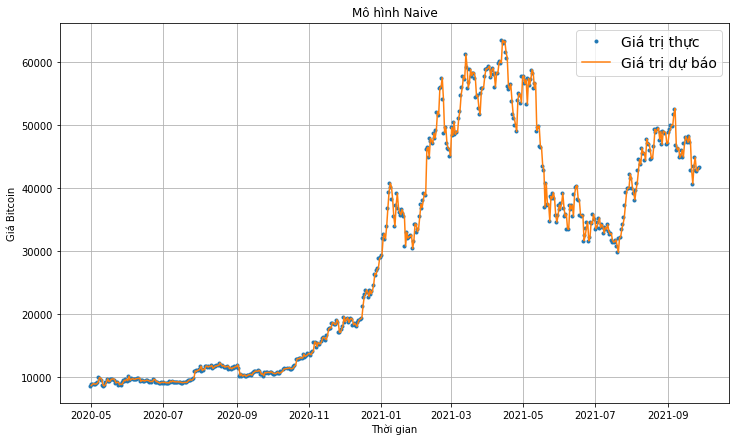

In [29]:
plt.figure(figsize=(12,7))
plot_time_series(X_test,y_test, label="Giá trị thực")
plot_time_series(X_test[1:],naive_forecast, label="Giá trị dự báo",format="-" )
plt.title("Mô hình Naive")

#### Đánh giá mô hình 

In [30]:
baseline_results = evaluate_model(y_test[1:],naive_forecast )
baseline_results

{'mae': 884.2807,
 'mape': 2.688989,
 'mase': 0.684088,
 'mse': 2059031.2,
 'rmse': 1434.9325}

`MAE` của mô hình là ~884 cho thấy độ chênh lệch trung bình giữa giá trị dự báo với giá trị thực tế là ~884$, có vẻ khá lớn. 

Ngoài `Naive model`, chúng ta có thể sử dụng một số mô hình khác làm mô hình cơ sở như  : 


| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

Tuy nhiên, chúng ta sẽ không đi sâu vào những mô hình này vì mục đích là xây dựng mô hình Deep Learning. 



### Model 1 : Dense Model (window = 7, horizon = 1)  

Thông thường, chuẩn bị dữ liệu cho một mô hình là một trong những phần lớn nhất của bất kỳ dự án học máy nào. Chúng ta đã viết sẵn một số hàm để chuẩn bị dữ liệu đáp ứng cho mô hình này. 

`model_1` bao gồm : 
+ 2 Dense layer với 256 hidden units và activation là `Relu`
+ Một output layer với activation là `Linear` 
+ Compile mô hình sử dụng :
  + optimizer là `Adam` 
  + loss function là `mae` 
+ Fit mô hình : 
  + batch size 128 (kích thước dữ liệu nhỏ)
  + epochs 100 
  + Sử dụng ModelCheckpoint callback để lưu mô hình học tốt nhất

Đầu tiên là import các thư viện trong tensorflow

In [31]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential

Tạo dữ liệu từ từ các hàm đã được viết trên 

In [32]:
HORIZON=1
WINDOW=7

In [33]:
windows, labels = create_windows(prices, window=WINDOW, horizon=HORIZON)
windows[:5],labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]), array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

Tách dữ liệu thành 2 phần `train` và `test` với `train_test_split()`. Dữ liệu không cần thay đổi thứ tự

In [34]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows,
                                                                          labels, 
                                                                          shuffle=False,
                                                                          train_size=0.8)


In [35]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]), array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [36]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((2045, 7), (2045, 1), (512, 7), (512, 1))

Dữ liệu đã được chia thành 2 phần :
+ `train_windows` : Dữ liệu được đưa vào mô hình học
+ `train_labels` : Mô hình học dữ liệu `train_windows` và nó lưu các đặc trưng trong dữ liệu học được này là `label` (một ký hiệu để ghi nhớ)
+ `test_windows` : Dữ liệu mô hình chưa từng được học qua để tìm đặc trưng và dự đoán `label` 
+ `test_labels` : Label thực của `test_windows` giúp đánh giá kết quả dự báo của mô hình 

OK, dữ liệu đã sẵn sàng, khởi tạo và train mô hình thôi 


#### Mô hình dự báo 

In [37]:
model_1 = Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(1)
])

model_1.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae"]
)

model_1_history = model_1.fit(
    train_windows,
    train_labels,
    epochs=100, 
    batch_size=128,
    validation_data=(test_windows,test_labels),   
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_1_dense_window_7_horizon_1")
    ] 
)

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 1518.2715 - mae: 1518.2715 - val_loss: 5116.2256 - val_mae: 5116.2256

Epoch 00001: val_mae improved from inf to 5116.22559, saving model to model_checkpoints/model_1_dense_window_7_horizon_1
INFO:tensorflow:Assets written to: model_checkpoints/model_1_dense_window_7_horizon_1/assets
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 410.2691 - mae: 410.2691 - val_loss: 2292.4221 - val_mae: 2292.4221

Epoch 00002: val_mae improved from 5116.22559 to 2292.42212, saving model to model_checkpoints/model_1_dense_window_7_horizon_1
INFO:tensorflow:Assets written to: model_checkpoints/model_1_dense_window_7_horizon_1/assets
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 238.4232 - mae: 238.4232 - val_loss: 1329.5562 - val_mae: 1329.5562

Epoch 00003: val_mae improved from 2292.42212 to 1329.55615, saving model to model_checkpoints/model_1_dense_window_7_horizon_1
INFO:ten

Load lại các trọng số mà mô hình đạt tốt nhất. 

In [38]:
model_1.load_weights(os.path.join(MODEL_CHECKPOINT_NAME, "model_1_dense_window_7_horizon_1"))

#### Đánh giá mô hình

Để đánh giá toàn bộ bằng các chỉ số đo lường dữ liệu hồi quy, trước tiên chúng ta sẽ dự báo giá của mỗi bitcoin từ dữ liệu `test_windows` 

In [39]:
model_1_preds = model_1.predict(test_windows, verbose=1)
model_1_preds[:5]

16/16 [==============================] - 0s 1ms/step


array([[8739.934],
       [8918.279],
       [9042.388],
       [8986.524],
       [8945.599]], dtype=float32)

In [40]:
model_1_results = evaluate_model(tf.squeeze(test_labels), tf.squeeze(model_1_preds))
model_1_results

{'mae': 883.3544,
 'mape': 2.6752357,
 'mase': 0.6887468,
 'mse': 2063334.8,
 'rmse': 1436.4313}

Chúng ta sẽ so sánh các chỉ số đo lường của `model_1` và những mô hình sau này với mô hình cơ sở để có sự so sánh trực quan hơn. Tạo hàm so sánh hiệu suất của mô hình với mô hình cơ sở

In [41]:
def compare_performance_baseline_with_current_model(baseline_performance, current_model_performance):
  for key, val in baseline_performance.items() : 
    print(f"""
    {key} 
    Mô hình cơ sở :{val}
    Mô hình hiện tại : {current_model_performance[key]} 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    {current_model_performance[key] - val}  
    ===================================================
    """)

In [42]:
compare_performance_baseline_with_current_model(baseline_results, model_1_results)


    mae 
    Mô hình cơ sở :884.2807006835938
    Mô hình hiện tại : 883.3543701171875 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -0.92633056640625  
    

    mse 
    Mô hình cơ sở :2059031.25
    Mô hình hiện tại : 2063334.75 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    4303.5  
    

    rmse 
    Mô hình cơ sở :1434.9324951171875
    Mô hình hiện tại : 1436.4312744140625 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    1.498779296875  
    

    mape 
    Mô hình cơ sở :2.6889889240264893
    Mô hình hiện tại : 2.6752357482910156 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -0.013753175735473633  
    

    mase 
    Mô hình cơ sở :0.6840879917144775
    Mô hình hiện tại : 0.6887468099594116 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.004658818244934082  
    


Có thể thấy `MAE` của mô hình `model_1` nhỏ hơn mô hình cơ sở nhưng giá trị sai số của nó vẫn còn rất lớn.

Text(0.5, 1.0, 'Dự báo giá bitcoin với mô hình Dense window 7 horizon 1')

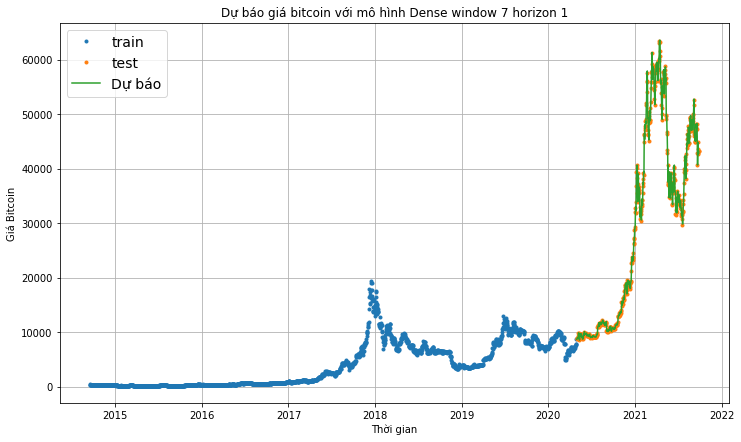

In [43]:
offset = 300
plt.figure(figsize=(12,7))
plot_time_series(X_train,y_train,label="train")
plot_time_series(X_test[-len(test_labels):], test_labels, label="test")
plot_time_series(X_test[-len(test_labels):], tf.squeeze(model_1_preds), label="Dự báo", format="-")
plt.title("Dự báo giá bitcoin với mô hình Dense window 7 horizon 1")

Text(0.5, 1.0, 'Biểu đồ giá bitcoin từ dữ liệu test và giá trị dự báo')

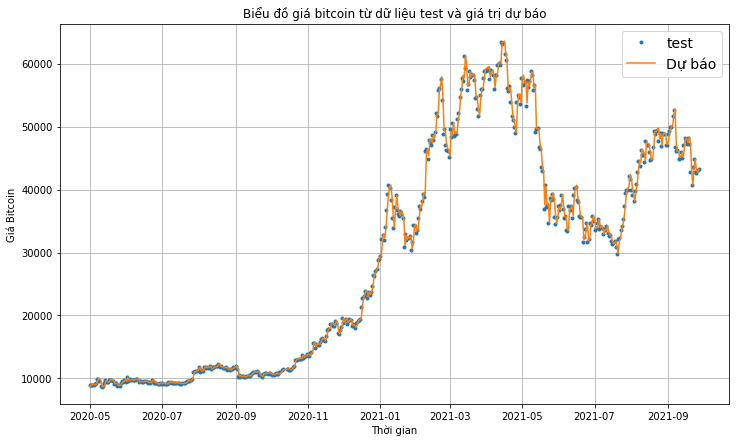

In [44]:
offset = 300
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels):], test_labels, label="test")
plot_time_series(X_test[-len(test_labels):], tf.squeeze(model_1_preds), label="Dự báo", format="-")
plt.title("Biểu đồ giá bitcoin từ dữ liệu test và giá trị dự báo")

### Model 2  : Dense Model (window = 30, horizon = 1) 

Ở mô hình trước chúng ta sử dụng giá bitcoin trong 1 tuần để dự đoán giá trị của nó cho ngày hôm sau. Trong mô hình này, thay vì dữ liệu 1 tuần, chúng ta sẽ sử dụng dữ liệu trong 1 tháng. Trước tiên, chúng ta cần chuẩn bị dữ liệu


In [ ]:
windows, labels = create_windows(prices, window=30, horizon=1) 

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows,
                                                                          labels, 
                                                                          train_size=0.8, 
                                                                          shuffle=False)

In [ ]:
train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [ ]:
train_windows.shape, train_labels.shape

((2027, 30), (2027, 1))

#### Mô hình dự báo

In [ ]:
model_2 = Sequential([
                      layers.Dense(256,activation="relu"), 
                      layers.Dense(256,activation="relu"), # Thêm 1 Dense vào mô hình
                      layers.Dense(1)
])
model_2.compile(
    loss="mae",
    optimizer="adam", 
    metrics=["mae"]
)

model_2_history = model_2.fit(
    train_windows, 
    train_labels, 
    batch_size=128, 
    epochs=100, 
    validation_data=(test_windows, test_labels),
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_2_dense_window_30_horizon_1")
    ]
)

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 991.9526 - mae: 991.9526 - val_loss: 4769.7837 - val_mae: 4769.7837

Epoch 00001: val_mae improved from inf to 4769.78369, saving model to model_checkpoints/model_2_dense_window_30_horizon_1
INFO:tensorflow:Assets written to: model_checkpoints/model_2_dense_window_30_horizon_1/assets
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 397.3589 - mae: 397.3589 - val_loss: 2180.4548 - val_mae: 2180.4548

Epoch 00002: val_mae improved from 4769.78369 to 2180.45483, saving model to model_checkpoints/model_2_dense_window_30_horizon_1
INFO:tensorflow:Assets written to: model_checkpoints/model_2_dense_window_30_horizon_1/assets
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 241.2371 - mae: 241.2371 - val_loss: 1366.9990 - val_mae: 1366.9990

Epoch 00003: val_mae improved from 2180.45483 to 1366.99902, saving model to model_checkpoints/model_2_dense_window_30_horizon_1
INFO:

Load các trọng số của mô hình đạt được tốt nhất

In [ ]:
model_2.load_weights(os.path.join(MODEL_CHECKPOINT_NAME, "model_2_dense_window_30_horizon_1"))

#### Đánh giá mô hình

In [ ]:
model_2_preds = model_2.predict(test_windows, verbose=1)
model_2_preds[:5]

16/16 [==============================] - 0s 1ms/step


array([[ 9104.361],
       [ 9356.746],
       [ 9975.488],
       [10077.288],
       [ 9943.35 ]], dtype=float32)

In [ ]:
model_2_results = evaluate_model(tf.squeeze(test_labels), tf.squeeze(model_2_preds))
model_2_results

{'mae': 940.8394,
 'mape': 2.8361206,
 'mase': 0.72030514,
 'mse': 2229111.8,
 'rmse': 1493.021}

`MAE` của `model_2` là ~909, lớn hơn so với với `model_1`, có vẻ khi lấy dữ liệu lịch trong khoảng thời gian lớn sẽ không đem lại hiệu quả dự đoán tốt. 

Chúng ta sẽ thử so sánh các chỉ số đo lường giữa `model_1` và `model_2` 

In [ ]:
compare_performance_baseline_with_current_model(model_1_results, model_2_results)


    mae 
    Mô hình cơ sở :880.616455078125
    Mô hình hiện tại : 940.8394165039062 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    60.22296142578125  
    

    mse 
    Mô hình cơ sở :2048969.0
    Mô hình hiện tại : 2229111.75 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    180142.75  
    

    rmse 
    Mô hình cơ sở :1431.4219970703125
    Mô hình hiện tại : 1493.02099609375 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    61.5989990234375  
    

    mape 
    Mô hình cơ sở :2.665220260620117
    Mô hình hiện tại : 2.83612060546875 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.1709003448486328  
    

    mase 
    Mô hình cơ sở :0.6866856813430786
    Mô hình hiện tại : 0.7203051447868347 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.033619463443756104  
    


Các chỉ số chênh lệch giữa 2 mô hình khá lớn. Điều này cũng cho thấy độ biến động của thị trường Bitcoin không hề nhỏ. 

In [ ]:
bitcoin_close_cloned = bitcoin_close.copy()

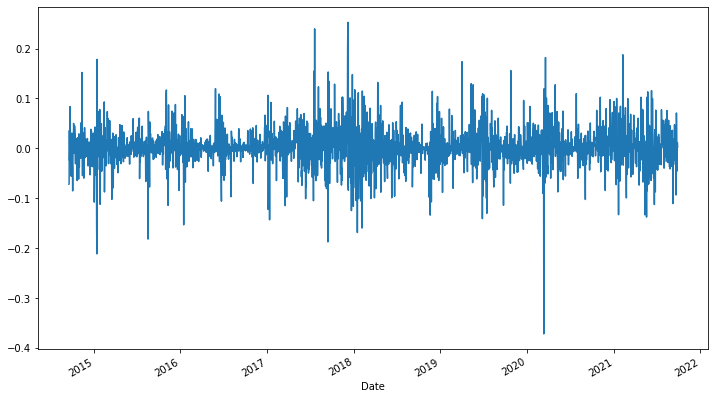

In [ ]:
bitcoin_close_cloned["Daily Diff"] = bitcoin_close_cloned["Close"] / bitcoin_close_cloned["Close"].shift(1) -1 
bitcoin_close_cloned["Daily Diff"].plot(figsize=(12,7))

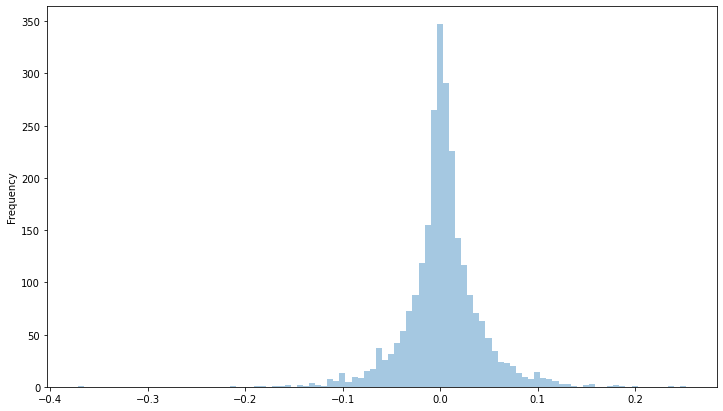

In [ ]:
bitcoin_close_cloned["Daily Diff"].plot.hist(bins=100,figsize=(12,7), alpha=0.4)

Text(0.5, 1.0, 'Biểu đồ giá trị bitcoin kèm giá trị dự báo')

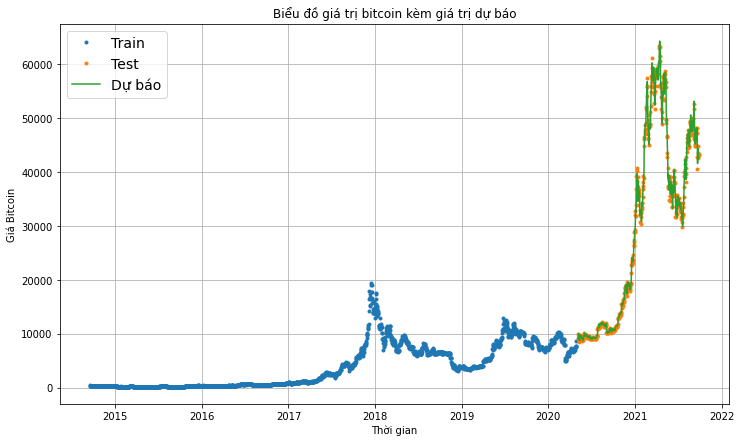

In [ ]:
offset = 300 
plt.figure(figsize=(12,7))
plot_time_series(X_train, y_train, label="Train")
plot_time_series(X_test[-len(test_labels):], test_labels, label="Test")
plot_time_series(X_test[-len(test_labels):],  model_2_preds, label="Dự báo", format="-" )
plt.title("Biểu đồ giá trị bitcoin kèm giá trị dự báo")

Text(0.5, 1.0, 'Biểu đồ dự báo giá trị bitcoin so với giá trị thực tế')

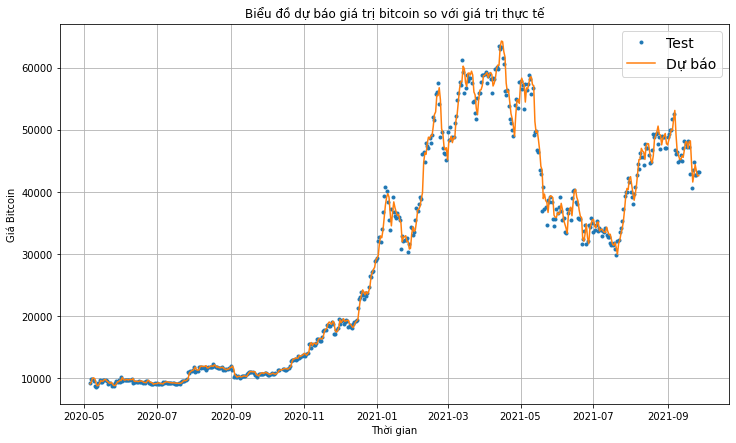

In [ ]:
offset = 300 
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels):], test_labels, label="Test")
plot_time_series(X_test[-len(test_labels):],  model_2_preds, label="Dự báo", format="-" )
plt.title("Biểu đồ dự báo giá trị bitcoin so với giá trị thực tế")

### Model 3 : Dense Model (window = 30, horizon = 7) 

Chúng ta sẽ xây dựng mô hình tương tự như `model_2`. Trước tiên, cần tạo dữ liệu train và test với windows=30 và horizon= 7

In [ ]:
windows, labels = create_windows(prices, window=30, horizon=7)

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows, 
                                                                          labels, 
                                                                          train_size=0.8, 
                                                                          shuffle=False)

In [ ]:
train_windows[0], train_labels[0], test_windows[0], test_labels[0]

(array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
        399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
        375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
        336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
        378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ]),
 array([383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
        383.15799 , 358.416992]),
 array([6438.644531, 6606.776367, 6793.624512, 6733.387207, 6867.527344,
        6791.129395, 7271.78125 , 7176.414551, 7334.098633, 7302.089355,
        6865.493164, 6859.083008, 6971.091797, 6845.037598, 6842.427734,
        6642.109863, 7116.804199, 7257.665039, 7189.424805, 6881.958496,
        6880.323242, 7117.20752 , 7429.724609, 7550.900879, 7569.936035,
        7679.867188, 7795.601074, 7807.058594, 8801.038086, 8658.553711]),
 array([8864.766602, 8988.59668 , 8897.46875 , 8

In [ ]:
train_windows.shape, train_labels.shape

((2022, 30), (2022, 7))

#### Mô hình dự báo 

In [ ]:
model_3 = Sequential([
                      layers.Dense(256,activation="relu"),
                      layers.Dense(256,activation="relu"),
                      layers.Dense(7),
])

model_3.compile(
    loss="mae", 
    optimizer="adam", 
    metrics=["mae"]
)

model_3_history = model_3.fit(
    train_windows,
    train_labels, 
    epochs=100,
    batch_size=128 ,
    validation_data=(test_windows, test_labels),
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_3_dense_window_30_horizon_7")
    ]
)

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 1392.2008 - mae: 1392.2008 - val_loss: 3190.7683 - val_mae: 3190.7686

Epoch 00001: val_mae improved from inf to 3190.76855, saving model to model_checkpoints/model_3_dense_window_30_horizon_7
INFO:tensorflow:Assets written to: model_checkpoints/model_3_dense_window_30_horizon_7/assets
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 503.0601 - mae: 503.0601 - val_loss: 2747.6826 - val_mae: 2747.6826

Epoch 00002: val_mae improved from 3190.76855 to 2747.68262, saving model to model_checkpoints/model_3_dense_window_30_horizon_7
INFO:tensorflow:Assets written to: model_checkpoints/model_3_dense_window_30_horizon_7/assets
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 394.9744 - mae: 394.9744 - val_loss: 2542.2554 - val_mae: 2542.2554

Epoch 00003: val_mae improved from 2747.68262 to 2542.25537, saving model to model_checkpoints/model_3_dense_window_30_horizon_7
INF

In [ ]:
model_3.load_weights(os.path.join(MODEL_CHECKPOINT_NAME, "model_3_dense_window_30_horizon_7"))

#### Đánh giá mô hình 

In [ ]:
model_3_preds = model_3.predict(test_windows, verbose=1)
model_3_preds

16/16 [==============================] - 0s 1ms/step


array([[ 8708.048,  8871.536,  8843.093, ...,  8986.899,  8937.145,
         9009.331],
       [ 8872.537,  9087.251,  9066.837, ...,  9206.206,  9162.145,
         9120.427],
       [ 9054.395,  9221.36 ,  9153.828, ...,  9342.624,  9196.403,
         9288.119],
       ...,
       [47696.965, 48859.645, 47701.016, ..., 48350.652, 48161.016,
        47377.426],
       [47423.594, 48185.438, 47356.805, ..., 47751.22 , 46974.812,
        46882.098],
       [44070.402, 44782.74 , 44307.926, ..., 44271.77 , 43433.785,
        43328.613]], dtype=float32)

Trong `model_3`, mô hình học dữ liệu sau đó nhận diện dữ liệu được học với 7 labels, tương tự khi dự đoán, mô hình đọc dữ liệu sau đó cũng tạo ra 7 giá trị dự đoán cho label. Tuy nhiên, để có thể đánh giá giá trị dự báo cũng như so sánh những giá trị này với mô hình khác, chúng ta cần 1 giá trị đại diện cho cả 7 dữ liệu đó. Vậy nên, chúng ta sẽ tính trung bình của 7 outputs này để lấy giá trị đại diện. 

In [ ]:
model_3_results = evaluate_model(tf.reduce_mean(test_labels,axis=1), 
                                 tf.reduce_mean(model_3_preds,axis=1)
                                 )
model_3_results

{'mae': 1600.666,
 'mape': 4.712535,
 'mase': 0.85391957,
 'mse': 6251080.5,
 'rmse': 2500.216}

Có thể thấy chỉ số `MAE` quá lớn so với các mô hình trên, điều đó khẳng định độ chênh lệch trung bình giữa giá trị dự báo và giá trị thực tế của Bitcoin là `$1637`. Chúng ta sẽ so sánh `model_2` và `model_3` với cùng số window = 30, chỉ có horizon của `model_2` là 1, còn `model_3` là 7. 

In [ ]:
compare_performance_baseline_with_current_model(model_2_results, model_3_results)


    mae 
    Mô hình cơ sở :940.8394165039062
    Mô hình hiện tại : 1600.666015625 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    659.8265991210938  
    

    mse 
    Mô hình cơ sở :2229111.75
    Mô hình hiện tại : 6251080.5 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    4021968.75  
    

    rmse 
    Mô hình cơ sở :1493.02099609375
    Mô hình hiện tại : 2500.216064453125 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    1007.195068359375  
    

    mape 
    Mô hình cơ sở :2.83612060546875
    Mô hình hiện tại : 4.7125349044799805 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    1.8764142990112305  
    

    mase 
    Mô hình cơ sở :0.7203051447868347
    Mô hình hiện tại : 0.8539195656776428 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.1336144208908081  
    


Text(0.5, 1.0, 'Biểu đồ dự báo giá với window 30 và horizon 7')

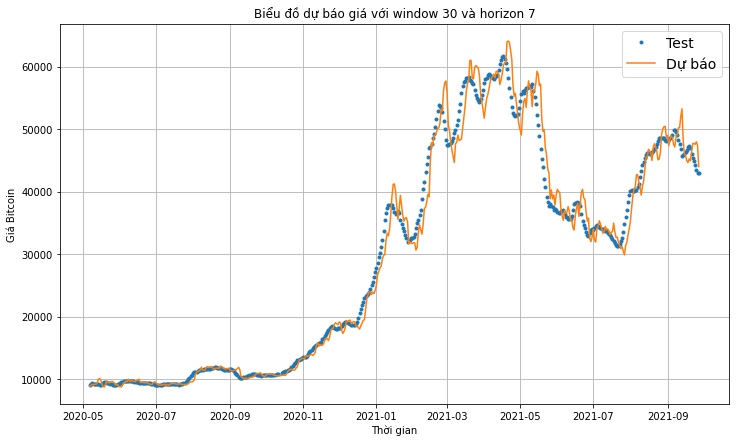

In [ ]:
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels):], tf.reduce_mean(test_labels,axis=1), label="Test")
plot_time_series(X_test[-len(test_labels):], tf.reduce_mean(model_3_preds,axis=1), label="Dự báo",format="-")
plt.title("Biểu đồ dự báo giá với window 30 và horizon 7")

Biểu đồ cho thấy các giá trị dự báo chênh lệch rất xa so với giá trị thực tế. Có thể khẳng định khi lấy dữ liệu lịch sử 30 ngày để dự báo giá trị của bitcoin cho 7 ngày tiếp theo sẽ không hiệu quả, các giá trị dự báo cho kết quả không chính xác dễ dẫn đến sai lầm trong quyết định giao dịch. 

### Model 4 : Conv1D

Trong mô hình này, chúng ta sẽ sử dụng Convolution neural network. `Conv1D` được sử dụng để giải quyết các vấn đề chuỗi theo trình tự seq2seq (sequence to sequence). 

Trong trường hợp của chúng ta, chuỗi input là dữ liệu giá Bitcoin 7 ngày trước và output là giá của ngày tiếp theo (theo thuật ngữ seq2seq).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)

Trước tiên, chúng ta sẽ tạo lại dữ liệu train và test với window=7, horizon=1

In [ ]:
windows, labels = create_windows(prices, window=7, horizon=1)

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows,
                                                                          labels,
                                                                          train_size=0.8,
                                                                          shuffle=False 
                                                                          )

In [ ]:
train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987]]), array([[423.204987],
        [411.574005]]))

In [ ]:
train_windows.shape, train_labels.shape

((2045, 7), (2045, 1))

Trước khi khởi tạo và train mô hình sử dụng [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), bạn cần lưu ý sau : 

+ Conv1D layer trong Tensorflow lấy input gồm `(batch_size, features_size, input_dims)`
+ Trong trường hợp của chúng ta, `batch_size` (theo mặc định là 32 nhưng chúng tôi có thể thay đổi nó) được xử lý theo giá trị khác sẽ là:
  + `features_size = WINDOW_SIZE` : `features_size` là kích thước các đặc tính của dữ liệu truyền vào, trong trường hợp này chỉ có 1 là `timesteps` hay chính là `WINDOW_SIZE` của Bitcoin. 
  + `input_dim = HORIZON` - mô hình của chúng ta xem dữ liệu giá trị `WINDOW_SIZE` (một tuần) tại một thời điểm để dự đoán` HORIZON` (một ngày)


In [ ]:
train_windows[0].shape

(7,)

Để khắc phục điều này, chúng ta có thể điều chỉnh hình dạng của tất cả các train_windows hoặc  có thể sử dụng `tf.keras.layers.Lamdba` để thực hiện việc này trong mô hình.



In [ ]:
example = train_windows[0]
expanded_example = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(example)
print(f"original shape : {example.shape}")
print(f"expanded shape: {expanded_example.shape}")
print(f"Origin values with expanded shape : {expanded_example}")

original shape : (7,)
expanded shape: (7, 1)
Origin values with expanded shape : [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


Bây giờ chúng ta đã thấy được công dụng của layer Lambda, bắt đầu xây dựng mô hình và train dữ liệu thôi


> 🔑 **Lưu ý:** Nếu bạn chạy mô hình bên dưới mà không có layer Lambda, bạn sẽ gặp lỗi input shape (một trong những lỗi phổ biến nhất khi xây dựng neural network).



#### Mô hình dự báo

In [ ]:
inputs = layers.Input(shape=(7,))
x = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = layers.Conv1D(filters=128,kernel_size=5,activation="relu", padding="causal")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1)(x)

model_4 = Model(inputs, outputs)


In [ ]:
model_4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            4608      
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae"]
)

In [ ]:
model_4_history = model_4.fit(
    train_windows,
    train_labels,
    epochs=100, 
    batch_size=128, 
    validation_data=(test_windows, test_labels),
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_4_conv1D")
    ]
)

Epoch 1/100
16/16 [==============================] - 1s 12ms/step - loss: 2415.4148 - mae: 2415.4148 - val_loss: 5495.2568 - val_mae: 5495.2568

Epoch 00001: val_mae improved from inf to 5495.25684, saving model to model_checkpoints/model_4_conv1D
INFO:tensorflow:Assets written to: model_checkpoints/model_4_conv1D/assets
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 455.6522 - mae: 455.6522 - val_loss: 1871.5209 - val_mae: 1871.5209

Epoch 00002: val_mae improved from 5495.25684 to 1871.52087, saving model to model_checkpoints/model_4_conv1D
INFO:tensorflow:Assets written to: model_checkpoints/model_4_conv1D/assets
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 276.4255 - mae: 276.4255 - val_loss: 1651.5778 - val_mae: 1651.5778

Epoch 00003: val_mae improved from 1871.52087 to 1651.57776, saving model to model_checkpoints/model_4_conv1D
INFO:tensorflow:Assets written to: model_checkpoints/model_4_conv1D/assets
Epoch 4/100
16/16 [====

In [ ]:
model_4.load_weights(os.path.join(MODEL_CHECKPOINT_NAME, "model_4_conv1D"))

#### Đánh giá mô hình 

In [ ]:
model_4_preds = model_4.predict(test_windows,verbose=1)
model_4_preds[:5]

16/16 [==============================] - 0s 1ms/step


array([[8774.332],
       [8872.027],
       [9027.039],
       [8975.104],
       [8955.979]], dtype=float32)

In [ ]:
model_4_results = evaluate_model(tf.squeeze(test_labels), tf.squeeze(model_4_preds))
model_4_results

{'mae': 905.1554,
 'mape': 2.7345343,
 'mase': 0.69240165,
 'mse': 2122716.0,
 'rmse': 1456.9543}

In [ ]:
compare_performance_baseline_with_current_model(baseline_results, model_4_results)


    mae 
    Mô hình cơ sở :884.2807006835938
    Mô hình hiện tại : 905.1553955078125 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    20.87469482421875  
    

    mse 
    Mô hình cơ sở :2059031.25
    Mô hình hiện tại : 2122716.0 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    63684.75  
    

    rmse 
    Mô hình cơ sở :1434.9324951171875
    Mô hình hiện tại : 1456.954345703125 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    22.0218505859375  
    

    mape 
    Mô hình cơ sở :2.6889889240264893
    Mô hình hiện tại : 2.73453426361084 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.045545339584350586  
    

    mase 
    Mô hình cơ sở :0.6840879917144775
    Mô hình hiện tại : 0.692401647567749 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.008313655853271484  
    


`MAE` của mô hình hiện tại vẫn chưa thể nhỏ hơn mô hình cơ sở. Tuy nhiên, các sai biệt này không đáng kể. 

Text(0.5, 1.0, 'Biểu đồ dự báo giá bitcoin so với giá trị thực')

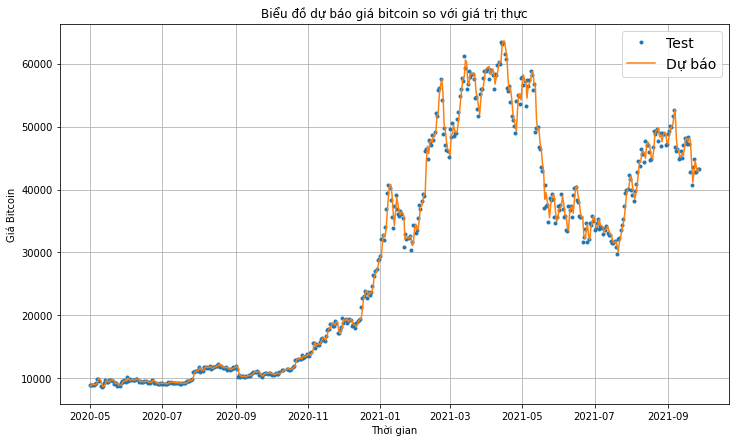

In [ ]:
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels): ], test_labels, label="Test")
plot_time_series(X_test[-len(test_labels): ], model_4_preds, label="Dự báo", format="-")
plt.title("Biểu đồ dự báo giá bitcoin so với giá trị thực")

### Model 5 : RNN 2 chiều sử dụng LSTM

Như bạn có thể đoán, chúng ta cũng có thể sử recurrent Neural Network để lập mô hình dữ liệu chuỗi thời gian tuần tự

Chúng ta sẽ sử dụng dữ liệu được tạo từ mô hình Conv1D, ngoại trừ lần này, mô hình sẽ là RNN sử dụng khả năng học của `LSTM` để lập mô hình dữ liệu Bitcoin. 

Một lần nữa, một trong những bước quan trọng nhất đối với mô hình LSTM là đưa dữ liệu của chúng ta vào đúng hình dạng.

`tf.keras.layers.LSTM()` lớp lấy một tensor với kích thước `[batch, timesteps, feature]`.


#### Mô hình dự báo

In [ ]:
inputs = layers.Input(shape=(7,))
x = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(units=128,activation="relu"))(x)
outputs = layers.Dense(1)(x)

model_5 = Model(inputs, outputs)

In [ ]:
model_5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               139264    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 139,521
Trainable params: 139,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_5.compile(
    loss="mae", 
    optimizer="adam",
    metrics=["mae"]
)

In [ ]:
model_5_history = model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels), 
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_5_RNN_LSTM")
    ]
)

Epoch 1/100
16/16 [==============================] - 3s 37ms/step - loss: 3409.7205 - mae: 3409.7205 - val_loss: 13389.0322 - val_mae: 13389.0322

Epoch 00001: val_mae improved from inf to 13389.03223, saving model to model_checkpoints/model_5_RNN_LSTM
INFO:tensorflow:Assets written to: model_checkpoints/model_5_RNN_LSTM/assets
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 805.2115 - mae: 805.2115 - val_loss: 3196.8767 - val_mae: 3196.8767

Epoch 00002: val_mae improved from 13389.03223 to 3196.87671, saving model to model_checkpoints/model_5_RNN_LSTM
INFO:tensorflow:Assets written to: model_checkpoints/model_5_RNN_LSTM/assets
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 330.1479 - mae: 330.1479 - val_loss: 2129.8125 - val_mae: 2129.8125

Epoch 00003: val_mae improved from 3196.87671 to 2129.81250, saving model to model_checkpoints/model_5_RNN_LSTM
INFO:tensorflow:Assets written to: model_checkpoints/model_5_RNN_LSTM/assets
Epoch

#### Đánh giá mô hình

In [ ]:
model_5.load_weights(os.path.join(MODEL_CHECKPOINT_NAME, "model_5_RNN_LSTM"))

In [ ]:
model_5_preds = model_5.predict(test_windows,verbose=1)
model_5_preds[:5]

16/16 [==============================] - 0s 2ms/step


array([[8715.992],
       [8905.192],
       [9008.497],
       [8955.577],
       [8911.826]], dtype=float32)

In [ ]:
model_5_results = evaluate_model(tf.squeeze(test_labels),
                                 tf.squeeze(model_5_preds))

model_5_results

{'mae': 908.90027,
 'mape': 2.752516,
 'mase': 0.69157237,
 'mse': 2127724.0,
 'rmse': 1458.672}

In [ ]:
compare_performance_baseline_with_current_model(baseline_results, model_5_results)


    mae 
    Mô hình cơ sở :884.2807006835938
    Mô hình hiện tại : 908.9002685546875 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    24.61956787109375  
    

    mse 
    Mô hình cơ sở :2059031.25
    Mô hình hiện tại : 2127724.0 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    68692.75  
    

    rmse 
    Mô hình cơ sở :1434.9324951171875
    Mô hình hiện tại : 1458.6719970703125 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    23.739501953125  
    

    mape 
    Mô hình cơ sở :2.6889889240264893
    Mô hình hiện tại : 2.752516031265259 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.06352710723876953  
    

    mase 
    Mô hình cơ sở :0.6840879917144775
    Mô hình hiện tại : 0.691572368144989 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.007484376430511475  
    


Có vẻ như ngay cả với RNN hỗ trợ LSTM, chúng ta cũng không thể đánh bại các kết quả mô hình ngây thơ. 


> 🔑 **Lưu ý:** Những thuật toán trong Neural Network là những thuật toán mạnh mẽ, chúng có thể được sử dụng để giải quyết cho hầu hết mọi vấn đề. Tuy nhiên, điều đó không có nghĩa là chúng sẽ đạt được kết quả hiệu quả hoặc có thể sử dụng được.

Text(0.5, 1.0, 'Biểu đồ dự báo so với giá trị thực của mô hình RNN (LSTM)')

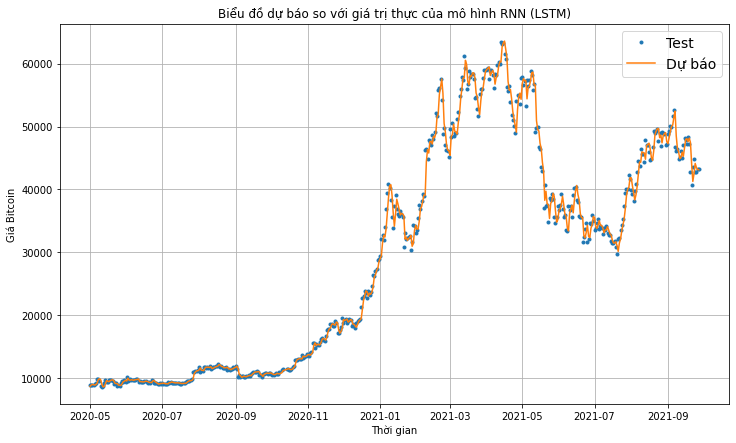

In [ ]:
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels):], test_labels, label="Test")
plot_time_series(X_test[-len(test_labels):], model_5_preds, label="Dự báo", format="-")
plt.title("Biểu đồ dự báo so với giá trị thực của mô hình RNN (LSTM)")

## Thiết lập mô hình sử dụng dữ liệu chuỗi thời gian nhiều biến

Cho đến thời điểm này, tất cả các mô hình của chúng ta hầu như không đánh bại được khả năng dự báo ngây thơ. Và tất cả chúng đều được train với một biến duy nhất (còn gọi là chuỗi thời gian đơn biến univariate): giá lịch sử của Bitcoin.

Nếu việc dự đoán giá Bitcoin bằng cách sử dụng giá Bitcoin không hoạt động tốt, thì việc cung cấp thêm thông tin cho mô hình của chúng ta cũng có thể hữu ích.

Bạn đã từng nghe đến Bitcoint Block Reward chưa? Bitcoint Block Reward có thể hiểu là phần thưởng khối bitcoin mới được trao cho những người khai thác tiền điện tử vì là người đầu tiên giải quyết một vấn đề toán học phức tạp và tạo ra một khối giao dịch bitcoin mới đã được xác minh. Những người khai thác sử dụng mạng máy tính để thực hiện công việc này và mỗi khi một khối (block) mới được tạo ra, nó sẽ được xác minh bởi tất cả những người khai thác cạnh tranh khác. Sau đó, một bài toán mới được đưa ra và các thợ đào bắt đầu lại.

Để giảm lạm phát, người tạo ra đồng tiền này giới hạn chỉ có 21 triệu bitcoin tương ứng với 210.000 block (1 block là 50 bitcoin). 

Khi mới thành lập, 1 block có 50 bitcoin. Nhưng cứ sau bốn năm hoặc lâu hơn, phần thưởng khối Bitcoin giảm đi một nửa. Ví dụ: kích thước phần thưởng khối đã giảm từ 50 (bắt đầu từ tháng 1 năm 2009) thành 25 vào ngày 28 tháng 11 năm 2012.


🔑 **Lưu ý**: Việc thêm một tính năng bổ sung vào tập dữ liệu, chẳng hạn như kích thước phần thưởng khối Bitcoin sẽ đưa dữ liệu từ đơn biến (chỉ giá lịch sử của Bitcoin) thành đa biến (giá Bitcoin cũng như kích thước phần thưởng khối).

Chúng ta sẽ cùng xem sử thay đổi của các khối bitcoin từ ngày thành lập (nguồn  [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving)): 

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

Dựa vào thông tin trên chúng ta sẽ đưa chúng thêm vào dữ liệu và mã hóa để train mô hình. Vì dữ liệu hiện tại chỉ đang dừng tại 2021 nên chúng ta sẽ không cần quan tâm 2 dòng cuối của bảng trên

In [ ]:
block_reward_1 = 50 
block_reward_2 = 25 
block_reward_3 = 12.5 
block_reward_4 = 6.25

In [ ]:
start_date_1 = pd.to_datetime("2009-01-03")
start_date_2 = pd.to_datetime("2012-11-28")
start_date_3 = pd.to_datetime("2016-05-09")
start_date_4 = pd.to_datetime("2020-05-11")

In [ ]:
# Nhân bản bitcoin_close thay vì xử lý trên dữ liệu gốc
bitcoin_close_multivariate = bitcoin_close.copy()
bitcoin_close_multivariate

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-09-23,44895.097656
2021-09-24,42839.750000
2021-09-25,42716.593750


In [ ]:
bitcoin_close_multivariate.loc[start_date_1:start_date_2, "Block Reward"] = block_reward_1
bitcoin_close_multivariate.loc[start_date_2:start_date_3, "Block Reward"] = block_reward_2
bitcoin_close_multivariate.loc[start_date_3:start_date_4, "Block Reward"] = block_reward_3
bitcoin_close_multivariate.loc[start_date_4:, "Block Reward"] = block_reward_4

In [ ]:
bitcoin_close_multivariate

,Close,Block Reward
Date,,
2014-09-17,457.334015,25.00
2014-09-18,424.440002,25.00
2014-09-19,394.795990,25.00
2014-09-20,408.903992,25.00
2014-09-21,398.821014,25.00
...,...,...
2021-09-23,44895.097656,6.25
2021-09-24,42839.750000,6.25
2021-09-25,42716.593750,6.25


Cột `Block Reward` tuy có kiểu số nhưng về bản chất nó là dữ liệu được định nghĩa cố định nên thuộc nhóm phân loại. VD : một chiếc xe có 2 bánh, 3 bánh hoặc 4 bánh... thì xe 2 bánh thuộc loại A chẳng hạn, 3 bánh thuộc loại B... Những bánh xe đó thuộc về phân loại chứ không giống như giá bitcoin thay đổi một cách ngẫu nhiên. 

Biểu diễn các cột này thành đồ thị. Vì cột `Close` và `Block Reward` không có cùng đơn vị đo, kích thước khác nhau, và một điều phổ biến khi xử lý dữ liệu trong machine learning là chuẩn hóa dữ liệu. Các dữ liệu được chuẩn hóa sẽ được đồng bộ đơn vị đo với nhau và chỉ dao động trong phạm vi 0-1. 

Chúng ta sẽ sử dụng `MinMaxScaler` trong sklearn để chuẩn hóa dữ liệu này

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
bitcoin_close_scaled = pd.DataFrame({
    "Close" : minmax_scale(bitcoin_close_multivariate["Close"]), 
    "Block Reward" : minmax_scale(bitcoin_close_multivariate["Block Reward"])
}, index=bitcoin_close_multivariate.index)

bitcoin_close_scaled

,Close,Block Reward
Date,,
2014-09-17,0.004409,1.0
2014-09-18,0.003890,1.0
2014-09-19,0.003422,1.0
2014-09-20,0.003645,1.0
2014-09-21,0.003485,1.0
...,...,...
2021-09-23,0.706147,0.0
2021-09-24,0.673690,0.0
2021-09-25,0.671745,0.0


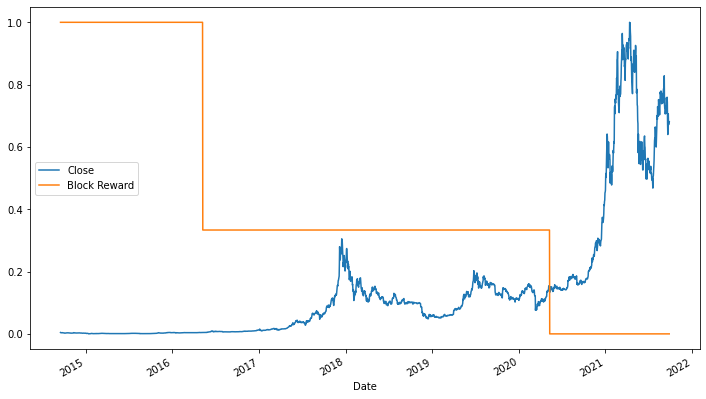

In [ ]:
bitcoin_close_scaled.plot(figsize=(12,7))

Khi chúng ta chia tỷ lệ phần thưởng khối và giá Bitcoin, chúng ta có thể thấy giá tăng lên khi phần thưởng khối giảm xuống, có lẽ thông tin này sẽ hữu ích cho hiệu suất của mô hình của chúng tôi.

### Tạo tập dữ liệu được đưa thành các window với pandas

In [ ]:
for i in range(1,8) : 
  bitcoin_close_multivariate[f"Price_{i}"] = bitcoin_close_multivariate["Close"].shift(i)

In [ ]:
# Xóa dữ liệu bị bỏ trống
bitcoin_close_multivariate.dropna(inplace=True)
bitcoin_close_multivariate

,Close,Block Reward,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7
Date,,,,,,,,,
2014-09-24,423.204987,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...,...
2021-09-23,44895.097656,6.25,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281,47267.519531,47783.359375
2021-09-24,42839.750000,6.25,44895.097656,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281,47267.519531
2021-09-25,42716.593750,6.25,42839.750000,44895.097656,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281


Bây giờ, dữ liệu ở mỗi dòng đã chứa 7 giá trị lịch sử và 1 giá trị hiện tại của bitcoin tương ứng cho dữ liệu để mô hình train và label để mô hình nhận biết đặc trưng của dữ liệu đó. Chúng ta sẽ chuyển chúng thành `windows` và `labels` như những mô hình trên. Và ở phần này sẽ có thêm `Block Reward` nên dữ liệu `windows` sẽ giống như thế này : 


```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```



In [ ]:
windows = bitcoin_close_multivariate.drop("Close",axis=1).to_numpy()
labels = bitcoin_close_multivariate["Close"].to_numpy()

windows[:5],labels[:5]

(array([[ 25.      , 435.790985, 402.152008, 398.821014, 408.903992,
         394.79599 , 424.440002, 457.334015],
        [ 25.      , 423.204987, 435.790985, 402.152008, 398.821014,
         408.903992, 394.79599 , 424.440002],
        [ 25.      , 411.574005, 423.204987, 435.790985, 402.152008,
         398.821014, 408.903992, 394.79599 ],
        [ 25.      , 404.424988, 411.574005, 423.204987, 435.790985,
         402.152008, 398.821014, 408.903992],
        [ 25.      , 399.519989, 404.424988, 411.574005, 423.204987,
         435.790985, 402.152008, 398.821014]]),
 array([423.204987, 411.574005, 404.424988, 399.519989, 377.181   ]))

Tách dữ liệu thành `train` và `test` không thay đổi thứ tự dữ liệu 

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows, 
                                                                          labels, 
                                                                          shuffle=False,
                                                                          train_size=0.8)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[ 25.      , 435.790985, 402.152008, 398.821014, 408.903992,
         394.79599 , 424.440002, 457.334015],
        [ 25.      , 423.204987, 435.790985, 402.152008, 398.821014,
         408.903992, 394.79599 , 424.440002],
        [ 25.      , 411.574005, 423.204987, 435.790985, 402.152008,
         398.821014, 408.903992, 394.79599 ],
        [ 25.      , 404.424988, 411.574005, 423.204987, 435.790985,
         402.152008, 398.821014, 408.903992],
        [ 25.      , 399.519989, 404.424988, 411.574005, 423.204987,
         435.790985, 402.152008, 398.821014]]),
 array([423.204987, 411.574005, 404.424988, 399.519989, 377.181   ]))

In [ ]:
train_windows.shape, train_labels.shape

((2045, 8), (2045,))

### Model 6 : mô hình Dense với nhiều biến

#### Mô hình dự báo

In [ ]:
model_6 = Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(1)
])

model_6.compile(
    loss="mae",
    optimizer="adam", 
    metrics=["mae"]
)

model_6_history = model_6.fit(
    train_windows, 
    train_labels, 
    epochs=100, 
    batch_size=32, 
    validation_data=(test_windows,test_labels),
    callbacks=[
               create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_6_multivariate_Dense")
    ]
)

Epoch 1/100
64/64 [==============================] - 1s 5ms/step - loss: 780.6049 - mae: 780.6049 - val_loss: 1515.3937 - val_mae: 1515.3937

Epoch 00001: val_mae improved from inf to 1515.39368, saving model to model_checkpoints/model_6_multivariate_Dense
INFO:tensorflow:Assets written to: model_checkpoints/model_6_multivariate_Dense/assets
Epoch 2/100
64/64 [==============================] - 0s 4ms/step - loss: 196.5461 - mae: 196.5461 - val_loss: 1234.2966 - val_mae: 1234.2966

Epoch 00002: val_mae improved from 1515.39368 to 1234.29663, saving model to model_checkpoints/model_6_multivariate_Dense
INFO:tensorflow:Assets written to: model_checkpoints/model_6_multivariate_Dense/assets
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 163.8706 - mae: 163.8706 - val_loss: 1271.5155 - val_mae: 1271.5155

Epoch 00003: val_mae did not improve from 1234.29663
Epoch 4/100
64/64 [==============================] - 0s 3ms/step - loss: 173.4045 - mae: 173.4045 - val_loss: 

#### Đánh giá mô hình

In [ ]:
model_6_preds = model_6.predict(test_windows,verbose=1)
model_6_preds[:5]

16/16 [==============================] - 0s 2ms/step


array([[8667.993],
       [8883.118],
       [9028.815],
       [8951.546],
       [8924.702]], dtype=float32)

In [ ]:
model_6_results = evaluate_model(tf.squeeze(test_labels), tf.squeeze(model_6_preds))
model_6_results

{'mae': 891.92615,
 'mape': 2.7093496,
 'mase': 0.6858262,
 'mse': 2058915.5,
 'rmse': 1434.8922}

In [ ]:
compare_performance_baseline_with_current_model(baseline_results,model_6_results )


    mae 
    Mô hình cơ sở :884.2807006835938
    Mô hình hiện tại : 891.9261474609375 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    7.64544677734375  
    

    mse 
    Mô hình cơ sở :2059031.25
    Mô hình hiện tại : 2058915.5 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -115.75  
    

    rmse 
    Mô hình cơ sở :1434.9324951171875
    Mô hình hiện tại : 1434.8922119140625 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -0.040283203125  
    

    mape 
    Mô hình cơ sở :2.6889889240264893
    Mô hình hiện tại : 2.7093496322631836 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.020360708236694336  
    

    mase 
    Mô hình cơ sở :0.6840879917144775
    Mô hình hiện tại : 0.6858261823654175 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.0017381906509399414  
    


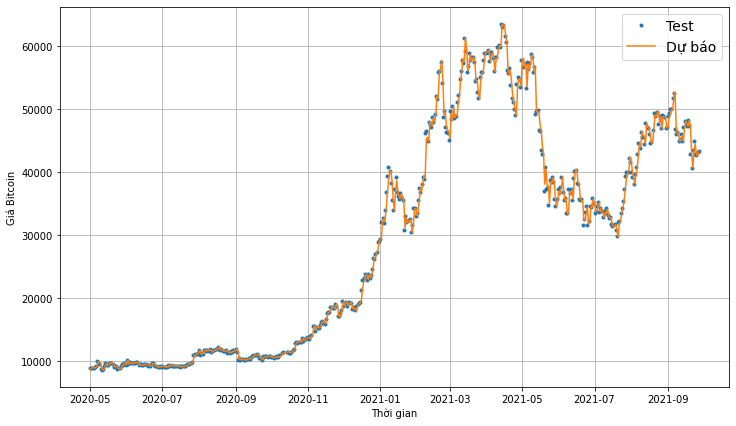

In [ ]:
plt.figure(figsize=(12,7))
plot_time_series(X_test[-len(test_labels):], test_labels, label="Test")
plot_time_series(X_test[-len(test_labels):], model_6_preds, label="Dự báo", format="-")

## Model 7: N-BEATS algorithm

Chúng ta đã thử hàng loạt các mô hình nhỏ với một vài layers, nhưng một trong những cách tốt nhất để cải thiện khả năng dự đoán của mô hình chính là tăng cường số lượng layers trong nó. 

Thuật toán [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting)](https://arxiv.org/pdf/1905.10437.pdf) chính là kiến trúc mà chúng ta cần để xây dựng một mô hình đủ phức tạp. 

Thuật toán N-BEATS tập trung vào các bài toán chuỗi thời gian đơn biến và đạt được hiệu suất hiện đại khi giành chiến thắng trong cuộc thi M4 (một cuộc thi dự báo).

Chúng ta sẽ tái tạo kiến ​​trúc thuật toán N-BEATS cho mô hình (Xem phần [3.3 của bài N-BEAT]((https://arxiv.org/pdf/1905.10437.pdf))) 

Chúng ta sẽ không xem qua tất cả các chi tiết trong bài báo, thay vào đó chúng tôi sẽ tập trung vào xây dựng mô hình dựa trên sơ đồ dưới đây:

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)

1. Tái tạo lại kiến trúc của mô hình [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 
2. Sử dụng cùng hyperparameter của bài báo có thể được tim thấy tại  [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Các bước thực hiện như sau : 
+ Tạo một layer tùy chọn có tên `NBeatsBlock` dưới dạng một class phụ [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
+ Triển khai kiến ​​trúc tùy chỉnh bằng các Functional API
+ Tìm một bài báo liên quan đến vấn đề của chúng tôi và xem nó diễn ra như thế nào

In [ ]:
class NBeatsBlock(layers.Layer) : 
  def __init__(self, 
           input_size : int,
           theta_size : int,
           horizon : int, 
           n_neurons : int, 
           n_layers : int, 
           **kwargs) : 
    super().__init__(**kwargs)
    self.input_size= input_size 
    self.theta_size = theta_size
    self.horizon = horizon 
    self.n_neurons = n_neurons 
    self.n_layers = n_layers 
    self.hidden = [layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs) : 
    x = inputs 
    for layer in self.hidden : 
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast     


Trong class thiết lập tùy chỉnh `NBeatsBlock` :
+ Là Một class kế thừa từ `tf.keras.layers.Layer` (Điều này cho chúng ta có thể sử dụng tất cả các phương thức từ `tf.keras.layers.Layer`) 
+ Một constructor (`def.__init()`) lấy tất cả các hyperparameter cũng như tham số `**kwargs` (tham số này lấy tất cả các hyperparameter chưa cấu hình trong constructor của class cha như là `input_shape`, `trainable`, `name`) 
+ Trong constructor, các khối kiến trúc của layers được tạo  với : 
  + hidden layers gồm 4 stack layers được kết nối đầy đủ với số `n_neurons` cùng với `Relu` activation function. 
  + Theta layer sử dụng `theta_size` làm hidden units với `linear` activation function
+ Phương thức `call()` là những gì cần thiết khi layers được gọi :
  + Phương thức này nhận `inputs` (dữ liệu lịch sử của bitcoin) qua mỗi hidden layers (sự xếp chồng của các layers được kết nối đầy đủ với Relu activation) 
  + Sau  khi `inputs` được truyền qua mỗi layers này, cuối cùng chúng sẽ được truyền qua `theta_layer` nơi mà backcast (dự đoán ngược với kích thước bằng `input_size`) và forecast (dự đoán tới có kích thước bằng `hirizon`) được trả về. 


In [ ]:
WINDOW=7
HORIZON=1 

In [ ]:
# Thiết lập class NBeatsBlock giả để đại diện cho các inputs và outputs 
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW, 
                                       theta_size=WINDOW+HORIZON, 
                                       horizon=HORIZON,
                                       n_neurons=256, 
                                       n_layers=4
                                       )

In [ ]:
input_dummy = tf.expand_dims(tf.range(WINDOW) + 1,axis=0)
input_dummy

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(input_dummy)
print(f"backcast : {tf.squeeze(backcast)}")
print(f"forecast : {tf.squeeze(forecast)}")

backcast : [-0.12282918 -0.319262    0.08796978  0.13295001 -0.1632156   0.09979738
 -0.0520628 ]
forecast : -0.547569990158081


### Chuẩn bị dữ liệu cho thuật toán N-BEATS 

Chúng tôi đã xây dựng kiến trúc `NBeatsBlocks` cơ bản. Nhưng trước khi sử dụng nó để sao chép toàn bộ kiến ​​trúc chung N-BEATS, chúng ta cần chuẩn bị dữ liệu.

Lần này, vì kiến ​​trúc mô hình lớn hơn, để đảm bảo quá trình train nhanh nhất có thể, chúng ta sẽ sử dụng `tf.data` API.

Và bởi vì thuật toán N-BEATS tập trung vào chuỗi thời gian đơn biến, chúng ta sẽ bắt đầu bằng cách thực hiện train và test trên bộ dữ liệu lịch sử 1 tuần dự đoán cho 1 giá trị vào ngày hôm sau (giống như chúng ta đã làm ở trên). 

Trước hết, chúng ta sẽ clone toàn bộ dữ liệu từ `bitcoin_close`, và tiến hành tạo giá bitcoin lịch sử 1 tuần. 




In [ ]:
bitcoin_close_nbeats = bitcoin_close.copy()

In [ ]:
for i in range(WINDOW) : 
  bitcoin_close_nbeats[f"Price_{i+1}"] = bitcoin_close_nbeats[f"Close"].shift(i+1)

In [ ]:
bitcoin_close_nbeats.head()

,Close,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [ ]:
bitcoin_close_nbeats.dropna(inplace=True)
bitcoin_close_nbeats

,Close,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-09-23,44895.097656,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281,47267.519531,47783.359375
2021-09-24,42839.750000,44895.097656,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281,47267.519531
2021-09-25,42716.593750,42839.750000,44895.097656,43574.507813,40693.675781,42843.800781,47260.218750,48278.363281


In [ ]:
windows =  bitcoin_close_nbeats.drop("Close",axis=1)
labels = bitcoin_close_nbeats["Close"]

windows[:5], labels[:5]

(               Price_1     Price_2  ...     Price_6     Price_7
 Date                                ...                        
 2014-09-24  435.790985  402.152008  ...  424.440002  457.334015
 2014-09-25  423.204987  435.790985  ...  394.795990  424.440002
 2014-09-26  411.574005  423.204987  ...  408.903992  394.795990
 2014-09-27  404.424988  411.574005  ...  398.821014  408.903992
 2014-09-28  399.519989  404.424988  ...  402.152008  398.821014
 
 [5 rows x 7 columns], Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.519989
 2014-09-28    377.181000
 Name: Close, dtype: float64)

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows,
                                                                          labels, 
                                                                          shuffle=False, 
                                                                          train_size=0.8)

In [ ]:
train_windows[:5], train_labels[:5]

(               Price_1     Price_2  ...     Price_6     Price_7
 Date                                ...                        
 2014-09-24  435.790985  402.152008  ...  424.440002  457.334015
 2014-09-25  423.204987  435.790985  ...  394.795990  424.440002
 2014-09-26  411.574005  423.204987  ...  408.903992  394.795990
 2014-09-27  404.424988  411.574005  ...  398.821014  408.903992
 2014-09-28  399.519989  404.424988  ...  402.152008  398.821014
 
 [5 rows x 7 columns], Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.519989
 2014-09-28    377.181000
 Name: Close, dtype: float64)

In [ ]:
train_windows.shape, train_labels.shape

((2045, 7), (2045,))

Bây giờ, chúng ta chuyển đổi những dữ liệu trên thành TensorFlow `tf.data.Dataset` để đảm bảo chúng chạy nhanh nhất. Các bước thực hiện như sau : 
+ Chuyển các mảng thành tập dữ liệu tensor sử dụng [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices). Lưu ý : `from_tensor_slices()` hoạt động tốt nhất khi dữ liệu đưa vào phù hợp với bộ nhớ ram. 
+ Kết hợp các labels và features tensors thành tập dữ liệu sử dụng  [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
+ Phân cụm và tìm nạp trước tập dữ liệu sử dụng [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) và [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch). Điều này đảm bảo thời gian tải từ CPU (chuẩn bị dữ liệu) đến GPU (tính toán trên dữ liệu) càng nhỏ càng tốt
  


In [ ]:
train_windows_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_windows_dataset,train_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)

test_windows_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_windows_dataset,test_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Thiết lập hyperparameter cho thuật toán NBeats

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

In [ ]:
N_EPOCHS=5000
N_NEURONS= 512
N_LAYERS=4
N_STACKS=30
INPUT_SIZE = WINDOW * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON


### Chuẩn bị sẵn sàng cho các kết nối còn lại

Hyperparameters đã sẵn sàng, bây giờ trước khi tạo mô hình N-BEATS, có hai layer đi qua đóng vai trò xoay vòng lớn trong kiến trúc.

Chúng là thứ tạo nên N-BEATS **xếp chồng các phần dư** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) bằng các phép tính cộng trừ : 
+ [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - thực hiện phép trừ từ list các input tensors với nhau 
+ [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - thêm list các input tensors to each other



In [ ]:
tensor_1 = tf.range(5)
tensor_2 = tf.range(5) + 5

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted : {layers.subtract([tensor_2,tensor_1])}")
print(f"Added : {layers.add([tensor_2,tensor_1])}")

Input tensors: [0 1 2 3 4] & [5 6 7 8 9]
Subtracted : [5 5 5 5 5]
Added : [ 5  7  9 11 13]


Cả hai layers functions này đều chuyển tiếp thẳng, có thể trừ hoặc cộng các đầu vào của chúng lại với nhau.

Sức mạnh của **xếp chồng phần dư (stacked residual)** hoặc **kết nối phần dư (residual connection)** đã được đề cập trong [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) nơi các tác giả có thể xây dựng một mạng nơ-ron sâu hơn nhưng ít phức tạp hơn (đây là những gì đã giới thiệu trong [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) 

> Kết nối phần dư là gì ? 
> **Kết nối phần dư** (còn được gọi là kết nối bỏ qua) liên quan đến một layer mạng neural sâu hơn nhận các output cũng như các inputs của một layer neural nông hơn.

Trong trường hợp N-BEATS, kiến ​​trúc sử dụng các kết nối phần dư: 
+ Trừ các backast outputs từ một khối trước đó từ các backcast inputs cho khối hiện tại
+ Thêm các forecast outputs từ tất cả các khối lại với nhau trong một ngăn xếp

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)

> Ưu điểm của kết nối phần dư là gì ? 

Trong thực tế, các kết nối dư có lợi cho việc train các mô hình sâu hơn (N-BEATS đạt đến ~ 150 layers, xem "Các cách tiếp cận này cung cấp lợi thế rõ ràng trong việc cải thiện khả năng train của các kiến ​​trúc sâu" trong phần 3.2 của [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))







### Khởi tạo và train mô hình 

Chúng ta sẽ làm như vậy bằng cách thực hiện các bước sau:
1. Thiết lập một instance của N-BEATS blocks layer sử dụng class `NBeatsBlock` 
2. Taọ một input layer cho ngăn xếp N-BEATS (sử dụng [Keras Functional API](https://www.tensorflow.org/guide/keras/functional)cho việc này)
3. Khởi tạo backcast và forecast cho mô hình với layer được tạo từ (1) 
4. Sử dụng vòng lặp để tạo các khối ngăn xếp N-BEATS chồng lên nhau
5. Sử dụng class `NBeatsBlock` trong vòng lặp để tạo `backcast_block` và `forecast_block` được gọi từ `residuals` của khối trước nó
6. Tạo chồng đôi phần dư bằng cách sử dụng `substract` và `add` layers
7. Tạo mô hình bằng cách đặt inputs và outputs với nhau.[`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)


In [ ]:
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE, 
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS
                                )
stack_input = layers.Input(shape=(INPUT_SIZE))
residuals, forecast = nbeats_block_layer(stack_input)

for i in range(N_STACKS-1) : 
  backcast_block, forecast_block = NBeatsBlock(input_size=INPUT_SIZE, 
                                               theta_size=THETA_SIZE, 
                                               horizon=HORIZON, 
                                               n_neurons=N_NEURONS,
                                               n_layers=N_LAYERS, 
                                               name=f"NBeatsBlock_{i}")(residuals)
  residuals = layers.subtract([residuals, backcast_block], name=f"subtract_{i}")
  forecast = layers.add([forecast, forecast_block], name=f"add_{i}")

model_7 = Model(stack_input, forecast)

In [ ]:
from tensorflow.keras.utils import plot_model

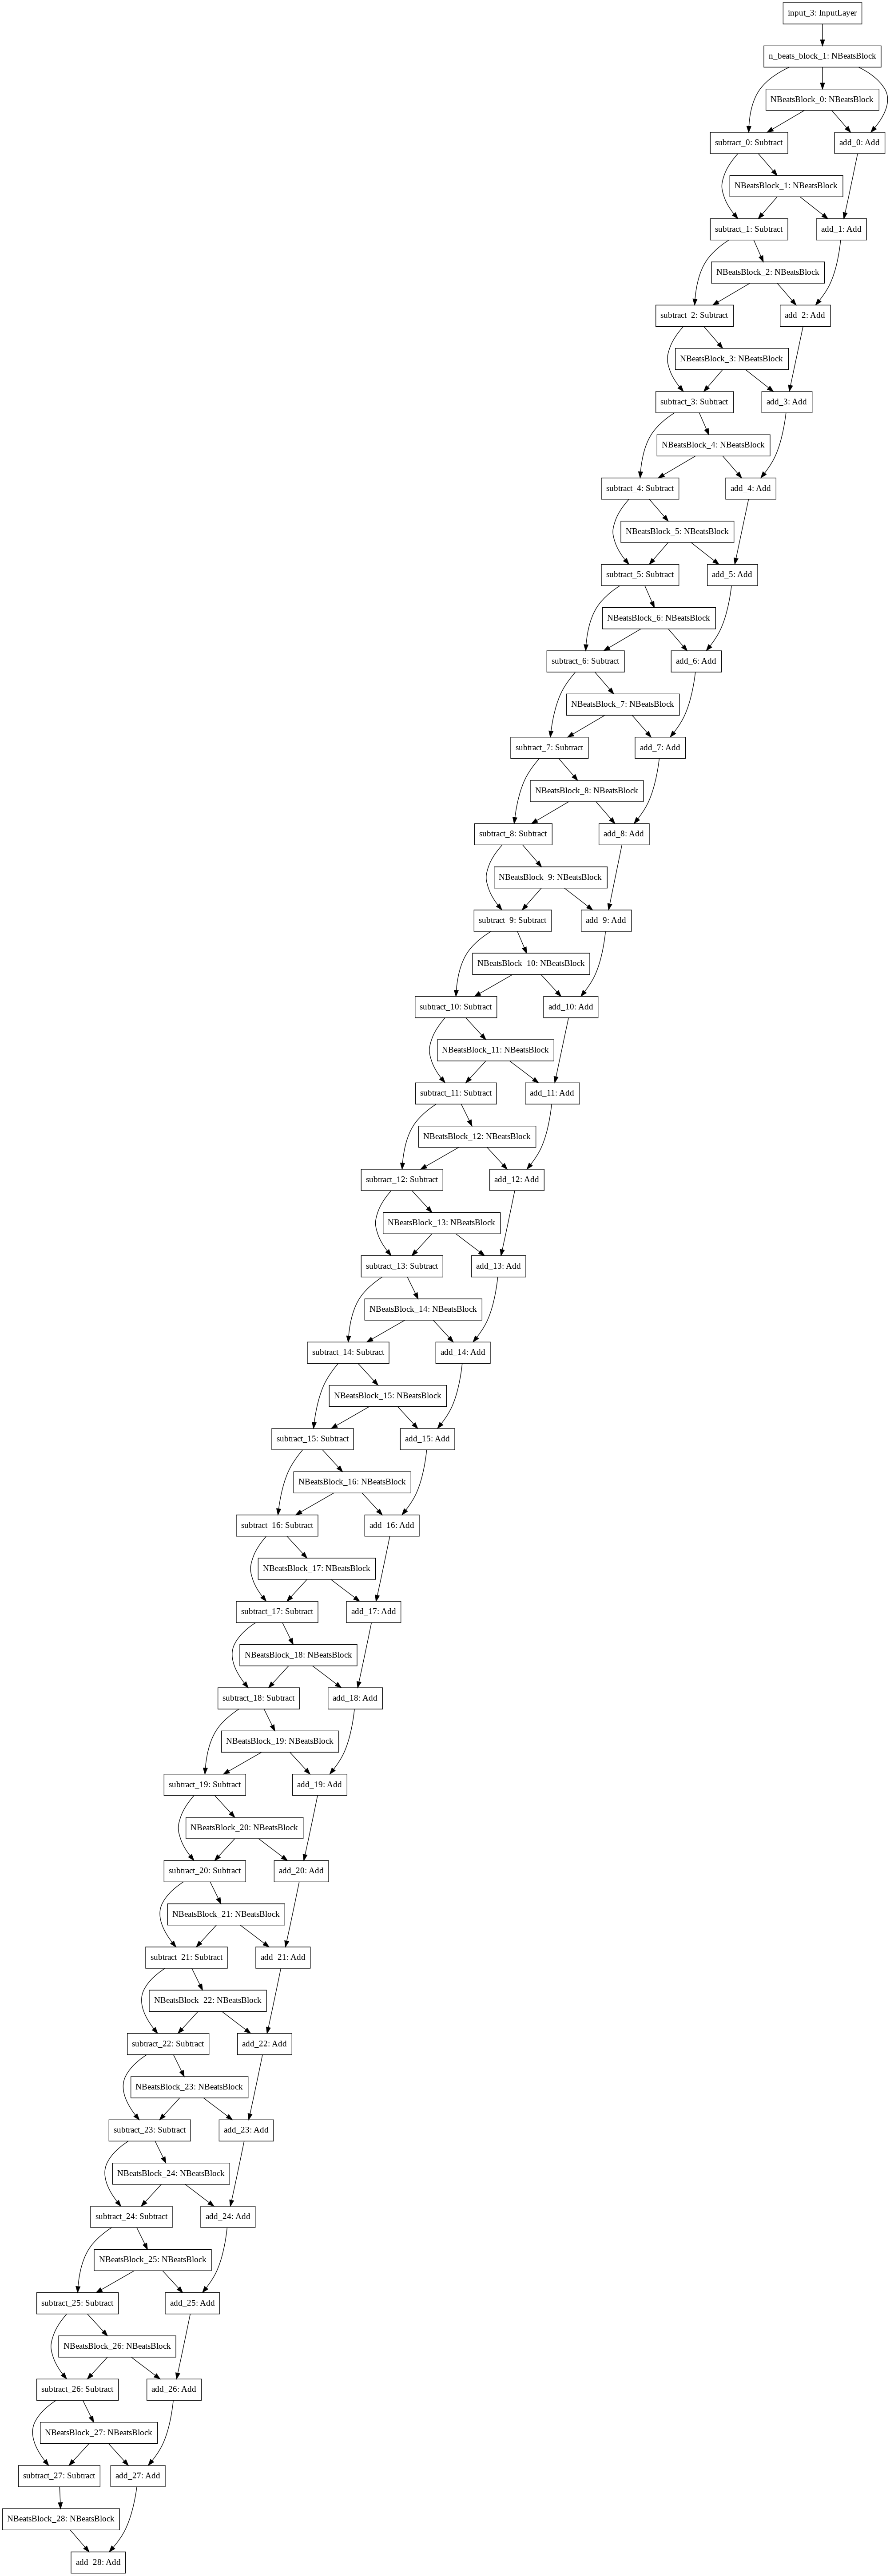

In [ ]:
plot_model(model_7)

In [ ]:
model_7.compile(
    loss="mae",
    optimizer="adam", 
    metrics=["mae"]
)

In [ ]:
model_7_history = model_7.fit(
    train_dataset, 
    steps_per_epoch=len(train_dataset),
    epochs=N_EPOCHS,
    validation_data=test_dataset, 
    validation_steps=len(test_dataset),
    callbacks=[
              #  create_model_checkpoint(MODEL_CHECKPOINT_NAME, "model_7_nbeats_block"), # Lưu mô hình sẽ mất rất nhiều thời gian
               tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True,verbose=1),
               tf.keras.callbacks.ReduceLROnPlateau(patience=10,factor=0.2,verbose=1)
    ]
)

Epoch 1/5000
64/64 [==============================] - 31s 331ms/step - loss: 435.7666 - mae: 435.7666 - val_loss: 1903.7694 - val_mae: 1903.7694
Epoch 2/5000
64/64 [==============================] - 21s 321ms/step - loss: 340.7522 - mae: 340.7522 - val_loss: 1557.8419 - val_mae: 1557.8419
Epoch 3/5000
64/64 [==============================] - 21s 329ms/step - loss: 316.3866 - mae: 316.3866 - val_loss: 1201.4478 - val_mae: 1201.4478
Epoch 4/5000
64/64 [==============================] - 20s 305ms/step - loss: 221.4625 - mae: 221.4625 - val_loss: 1101.5228 - val_mae: 1101.5228
Epoch 5/5000
64/64 [==============================] - 20s 310ms/step - loss: 232.4275 - mae: 232.4275 - val_loss: 2723.0891 - val_mae: 2723.0891
Epoch 6/5000
64/64 [==============================] - 19s 300ms/step - loss: 211.7923 - mae: 211.7923 - val_loss: 989.2821 - val_mae: 989.2821
Epoch 7/5000
64/64 [==============================] - 20s 309ms/step - loss: 202.5597 - mae: 202.5597 - val_loss: 937.9144 - val_mae

### Đánh giá mô hình 

In [ ]:
model_7_preds = model_7.predict(test_dataset,verbose=1)
model_7_preds[:5]

16/16 [==============================] - 1s 69ms/step


array([[8726.001],
       [8856.601],
       [9058.214],
       [8956.762],
       [8901.828]], dtype=float32)

In [ ]:
model_7_results = evaluate_model(tf.squeeze(test_labels), tf.squeeze(model_7_preds))
model_7_results

{'mae': 884.83325,
 'mape': 2.6844032,
 'mase': 0.6855545,
 'mse': 2046269.4,
 'rmse': 1430.4788}

In [ ]:
compare_performance_baseline_with_current_model(baseline_results, model_7_results)


    mae 
    Mô hình cơ sở :884.2807006835938
    Mô hình hiện tại : 884.833251953125 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.55255126953125  
    

    mse 
    Mô hình cơ sở :2059031.25
    Mô hình hiện tại : 2046269.375 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -12761.875  
    

    rmse 
    Mô hình cơ sở :1434.9324951171875
    Mô hình hiện tại : 1430.478759765625 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -4.4537353515625  
    

    mape 
    Mô hình cơ sở :2.6889889240264893
    Mô hình hiện tại : 2.68440318107605 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    -0.004585742950439453  
    

    mase 
    Mô hình cơ sở :0.6840879917144775
    Mô hình hiện tại : 0.6855545043945312 
    Sai biệt giữa mô hình hiện tại với mô hình cơ sở : 
    0.001466512680053711  
    


## So sánh các chỉ số đo lường của các mô hình

Chúng ta đã train qua khá nhiều mô hình, đến lúc cần phải nhìn nhận lại các kết quả đo lường của các mô hình 

In [ ]:
results = pd.DataFrame({
    "baseline" : baseline_results , 
    "Dense_window_7_horizon_1" : model_1_results, 
    "Dense_window_30_horizon_1" : model_2_results, 
    "Dense_window_30_horizon_7" : model_3_results, 
    "Conv1D" : model_4_results, 
    "RNN_Bi_LSTM" : model_5_results, 
    "Dense_Multivariate" : model_6_results, 
    "NBeats Algorithm" : model_7_results
})

results = results.T
results

,mae,mse,rmse,mape,mase
baseline,884.280701,2059031.250,1434.932495,2.688989,0.684088
Dense_window_7_horizon_1,880.616455,2048969.000,1431.421997,2.665220,0.686686
Dense_window_30_horizon_1,940.839417,2229111.750,1493.020996,2.836121,0.720305
Dense_window_30_horizon_7,1600.666016,6251080.500,2500.216064,4.712535,0.853920
Conv1D,905.155396,2122716.000,1456.954346,2.734534,0.692402
RNN_Bi_LSTM,908.900269,2127724.000,1458.671997,2.752516,0.691572
Dense_Multivariate,891.926147,2058915.500,1434.892212,2.709350,0.685826
NBeats Algorithm,884.833252,2046269.375,1430.478760,2.684403,0.685555


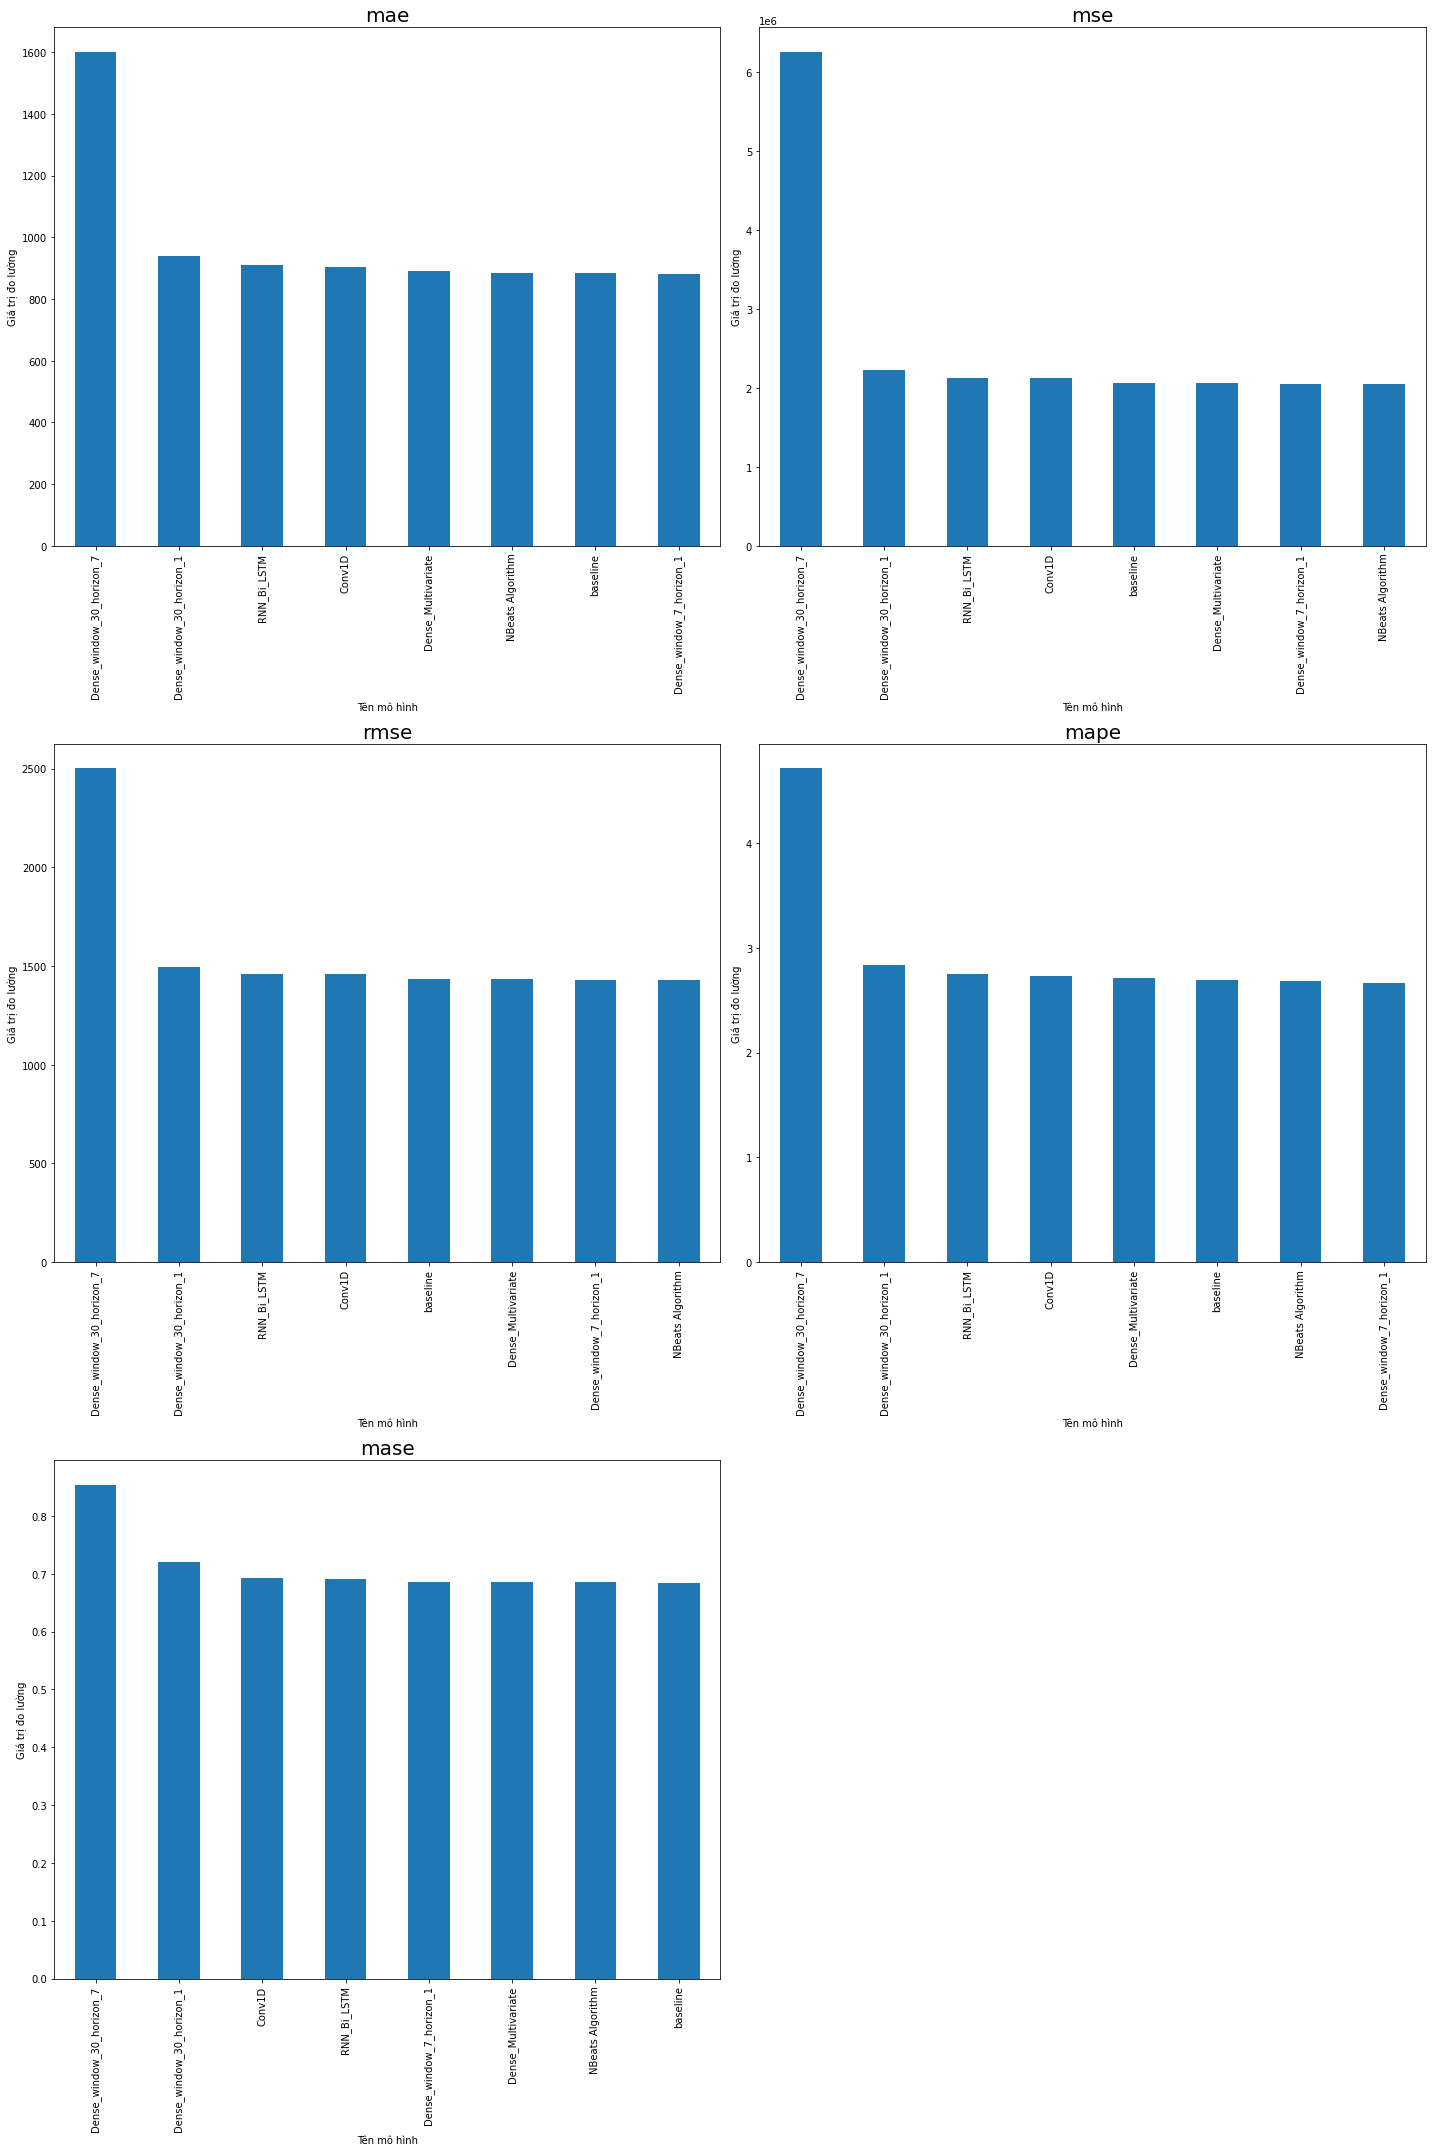

In [ ]:
fig = plt.figure(figsize=(20,30))
for i, col in enumerate(results.columns) : 
  plt.subplot(3,2,i+1) 
  results.sort_values(col,ascending=False)[col].plot.bar()
  plt.title(col, fontsize=20)
  plt.xlabel(f"Tên mô hình")
  plt.ylabel("Giá trị đo lường")
fig.tight_layout()

Để so sánh đơn giản nhất, chúng ta sẽ so sánh `mae` của tất cả các mô hình. 

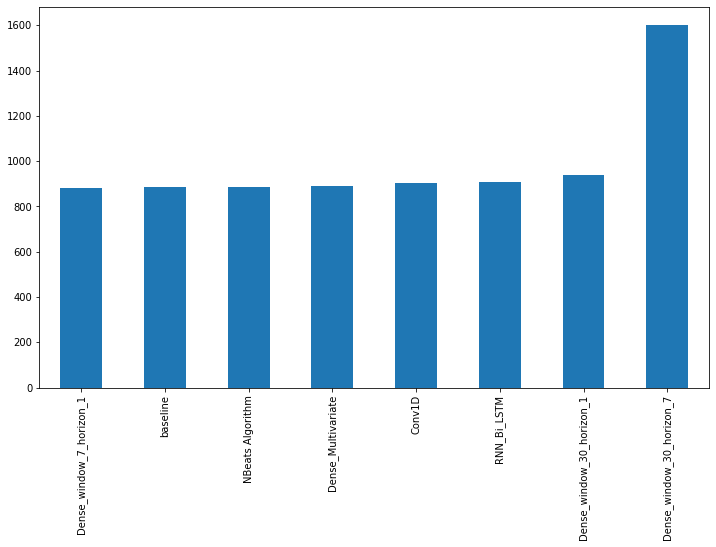

In [ ]:
results.sort_values("mae",ascending=True)["mae"].plot.bar(figsize=(12,7))

Chỉ số `mae` đo lường mức chênh lệch trung bình giữa giá trị thực và giá trị dự báo. Chỉ số này càng nhỏ càng cho thấy khả năng dự báo càng gần với giá trị thực tế. 

Trong biểu đồ trên, mô hình có chỉ số `mae` thấp nhất là `Dense_window_7_horizon_1`, các mô hình còn lại ngoại trừ `Dense_window_30_horizon_7` cũng có `mae` khá gần với nhau. Như vậy `Dense_window_7_horizon_1` là mô hình tốt nhất. 

## Xác định thời điểm biến động 

Dù đã thực hiện nhiều phương pháp train mô hình từ đơn giản cho đến phức tạp, nhưng chỉ số `mae` đều cho ra những giá trị rất lớn. Có thể thấy rằng thị trường bitcoin đã có những thời điểm xảy ra biến động rất lớn, khiến giá trị của nó có lúc nhảy vọt lên rất cao cũng có lúc rớt xuống rất thê thảm chỉ trong một thời gian ngắn. 

Chúng ta cần xác định giá trị của bitcoin biến động ra sao :

In [72]:
bitcoin_close_report = bitcoin_close.copy()

In [73]:
bitcoin_close_report["Daily Change"] = np.log(bitcoin_close_report["Close"] / bitcoin_close_report["Close"].shift(1))

In [74]:
bitcoin_close_report

,Close,Daily Change
Date,,
2014-09-17,457.334015,NaN
2014-09-18,424.440002,-0.074643
2014-09-19,394.795990,-0.072402
2014-09-20,408.903992,0.035111
2014-09-21,398.821014,-0.024968
...,...,...
2021-09-23,44895.097656,0.029856
2021-09-24,42839.750000,-0.046862
2021-09-25,42716.593750,-0.002879


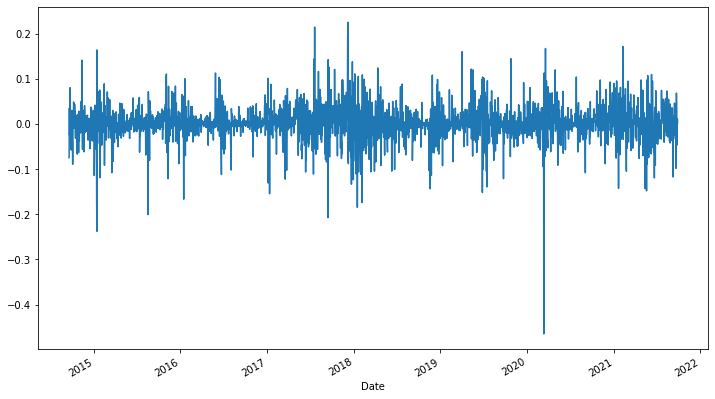

In [75]:
bitcoin_close_report["Daily Change"].plot(figsize=(12,7))

Tiếp theo, chúng ta sẽ lấy dữ liệu dự báo của mô hình tốt nhất và so sánh với giá trị thực để xác định mức chênh lệch

In [76]:
start_date_test = bitcoin_close_report.iloc[-len(test_labels)].name
start_date_test


Timestamp('2020-05-01 00:00:00')

In [77]:
bitcoin_close_report.loc[start_date_test:, "Prediction"] = tf.squeeze(model_1_preds).numpy()
bitcoin_close_report

,Close,Daily Change,Prediction
Date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,-0.074643,NaN
2014-09-19,394.795990,-0.072402,NaN
2014-09-20,408.903992,0.035111,NaN
2014-09-21,398.821014,-0.024968,NaN
...,...,...,...
2021-09-23,44895.097656,0.029856,43244.468750
2021-09-24,42839.750000,-0.046862,44852.375000
2021-09-25,42716.593750,-0.002879,43162.050781


In [78]:
bitcoin_close_report["Difference"] = bitcoin_close_report["Close"] - bitcoin_close_report["Prediction"]
bitcoin_close_report

,Close,Daily Change,Prediction,Difference
Date,,,,
2014-09-17,457.334015,NaN,NaN,NaN
2014-09-18,424.440002,-0.074643,NaN,NaN
2014-09-19,394.795990,-0.072402,NaN,NaN
2014-09-20,408.903992,0.035111,NaN,NaN
2014-09-21,398.821014,-0.024968,NaN,NaN
...,...,...,...,...
2021-09-23,44895.097656,0.029856,43244.468750,1650.628906
2021-09-24,42839.750000,-0.046862,44852.375000,-2012.625000
2021-09-25,42716.593750,-0.002879,43162.050781,-445.457031


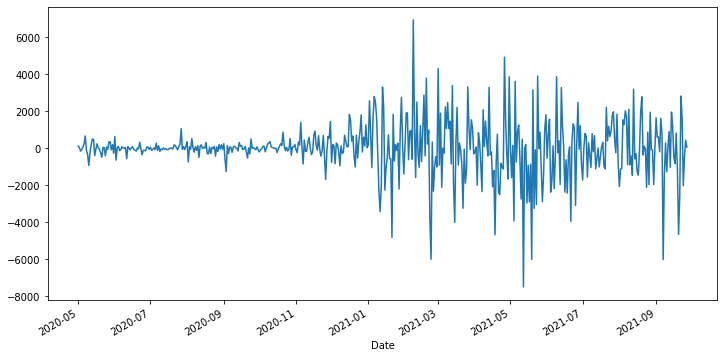

In [79]:
bitcoin_close_report["Difference"].plot(figsize=(12,6))

In [80]:
bitcoin_close_report.dropna(axis=0).sort_values("Difference")

,Close,Daily Change,Prediction,Difference
Date,,,,
2021-05-12,49150.535156,-0.142967,56641.390625,-7490.855469
2021-09-07,46811.128906,-0.117232,52824.585938,-6013.457032
2021-05-19,37002.441406,-0.148107,43001.835938,-5999.394532
2021-02-23,48824.425781,-0.104585,54817.570312,-5993.144532
2021-01-21,30825.699219,-0.142528,35636.820312,-4811.121094
...,...,...,...,...
2021-06-09,37345.121094,0.109474,33464.468750,3880.652344
2021-05-24,38705.980469,0.107222,34793.273438,3912.707032
2021-03-01,49631.242188,0.094901,45317.957031,4313.285157


Độ biến động của bitcoin theo từng tháng

In [102]:
bitcoin_close_resport_clean = bitcoin_close_report.dropna(axis=0)

bitcoin_close_resport_clean.groupby([bitcoin_close_resport_clean.index.month])["Difference"].mean()

Date
1      46.223916
2     252.609375
3     304.718876
4    -172.508333
5    -399.229020
6     -93.347184
7      91.992282
8      18.311224
9    -137.559159
10     74.961670
11    144.308561
12    236.722467
Name: Difference, dtype: float64

Độ biến động của bitcoin theo từng quý

In [100]:
bitcoin_close_resport_clean.groupby([bitcoin_close_resport_clean.index.quarter])["Difference"].mean()

Date
1    199.469879
2   -233.738686
3     -5.536214
4    154.680675
Name: Difference, dtype: float64